In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.copy_on_write = True

# Loading data

In [2]:
df = pd.read_csv('customer.csv')

# Exploratory Data Analysis and Preprocessing

Here we conduct a initial analysis of the dataset:

In [3]:
print("Seeing the first 10 lines of the dataset: \n")
print(df.head(10))
print('\n')
print("Counting the missing values in each column: \n")
print(df.isnull().sum())
print('\n')
print("Dataset info: \n")
print(df.info())
print("\n")
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("\n")
print(df.describe())

Seeing the first 10 lines of the dataset: 

   Unnamed: 0        custid     sex is_employed   income      marital_status  \
0           7  000006646_03    Male        True  22000.0       Never married   
1           8  000007827_01  Female         NaN  23200.0  Divorced/Separated   
2           9  000008359_04  Female        True  21000.0       Never married   
3          10  000008529_01  Female         NaN  37770.0             Widowed   
4          11  000008744_02    Male        True  39000.0  Divorced/Separated   
5          15  000011466_01    Male         NaN  11100.0             Married   
6          17  000015018_01  Female        True  25800.0             Married   
7          19  000017314_02  Female         NaN  34600.0             Married   
8          20  000017383_04  Female        True  25000.0       Never married   
9          21  000017554_02    Male        True  31200.0             Married   

   health_ins                  housing_type  num_vehicles  age state_of_res

There are some null values in some columns that appear to be null for the same rows. In that case, dropping the rows could be a reasonable solution, if it doesn't cause a significant data loss.

In [4]:
n_null = len(df.loc[(df["housing_type"].isnull() == True) & (df["num_vehicles"].isnull() == True) 
                    & (df["gas_usage"].isnull() == True) & (df["recent_move_b"].isnull() == True)])
print(n_null)

1686


In [5]:
print(f"Percentage of data to be dropped: {(n_null / len(df)) * 100:.2f}%")

Percentage of data to be dropped: 2.33%


Since the rows are the same and it's just a 2% data loss, we decided to drop these rows.

In [6]:
df = df.dropna(subset=["housing_type"])

# checking if dropping worked
print(len(df[df["housing_type"].isnull() == True])) 
df[df["recent_move_b"].isnull() == True]

0


,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
10030,14009,001148287_01,Female,False,5000.0,Married,True,Homeowner with mortgage/loan,0.0,42,California,8962,3.0,4,NaN


There was still one missing value in the column recent_move_b so we replaced it with the mode:

In [7]:
mode = df["recent_move_b"].mode()[0]
df["recent_move_b"] = df["recent_move_b"].fillna(mode)
print(len(df[df["recent_move_b"].isnull() == True]))

0


Now we take a look at the unique values inside each column, to know which ones are categorical and which and how many categories are there.

In [8]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("\n")

Unnamed: 0
[    7     8     9 ... 99997 99998 99999]
70772


custid
['000006646_03' '000007827_01' '000008359_04' ... '001507219_01'
 '001513103_01' '001519624_01']
70772


sex
['Male' 'Female']
2


is_employed
[True nan False]
3


income
[22000. 23200. 21000. ... 25110. 18010. 26850.]
4423


marital_status
['Never married' 'Divorced/Separated' 'Widowed' 'Married']
4


health_ins
[ True False]
2


housing_type
['Homeowner free and clear' 'Rented' 'Homeowner with mortgage/loan'
 'Occupied with no rent']
4


num_vehicles
[0. 2. 1. 5. 3. 4. 6.]
7


age
[ 24  82  31  93  67  76  26  73  27  54  61  64  55  65  33  47  68  46
  58  43  41  62  21  78  32  59  29  70  30  28  86  35  34  40  72  60
  25  79  22  42  44  81  50  45  63  57  39  71  38  49  69  37  66  53
  36  23  75  88  51  85  52  83  77  56  48 100  74  89  80  84   0  87
 120  91 110 114  94  90  96  92  95]
81


state_of_res
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Dist

We can see unnamed and custid columns have unique values, which won't be usefull for predictions. Also, we can see all numeric values are integers, and the one with more variability is income, which is expected.

Also we can see there are "nan" values on the is_employed column, which actually represent not in workforce, as said in the data dictionary. Thus, we have to be carefull to not treat the "nan" values as null values, but as a category.

Now, we can take a look on the age distribution to determine if the customers are mostly young, middle-aged or seniors.

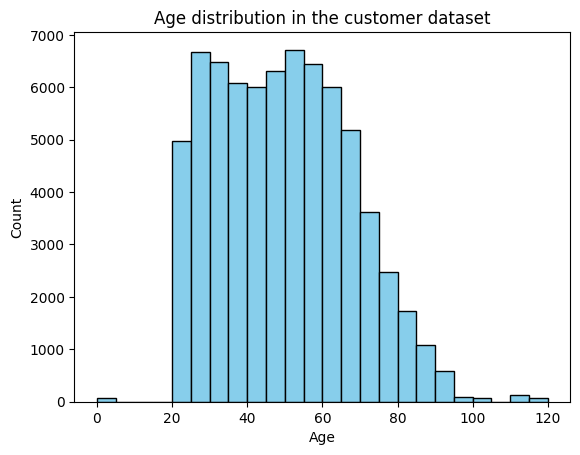

In [9]:
plt.hist(df["age"], bins=24, edgecolor='black', color='skyblue')
plt.title("Age distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Age")
plt.show()

The histogram shows there are mostly young adults and middle-aged customers. Each bin contains a 5 year interval. There are also potential errors/outliers (values near 120).

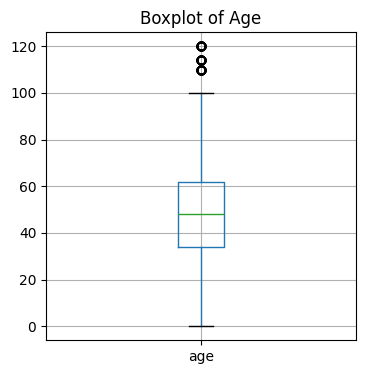

In [10]:
df.boxplot(column="age", figsize=(4,4))
plt.title('Boxplot of Age')
plt.show()

There are indeed some outliers that need to be addressed.

Now, we take a look at the income:

In [11]:
df["income"].describe()

count    7.077200e+04
mean     4.263163e+04
std      5.864181e+04
min     -6.900000e+03
25%      1.130000e+04
50%      2.748500e+04
75%      5.205500e+04
max      1.257000e+06
Name: income, dtype: float64

**Note**: Negative values represent loss.

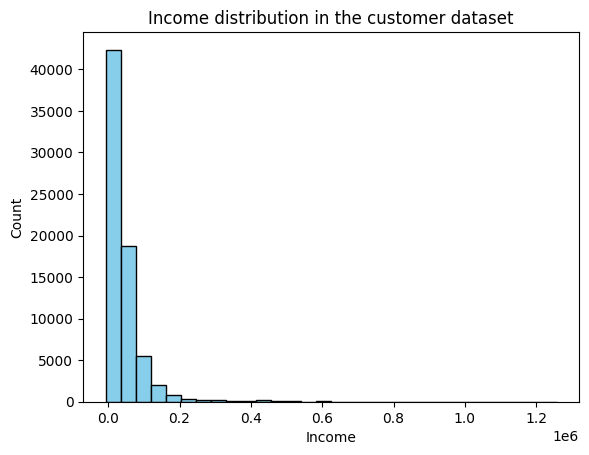

In [12]:
plt.hist(df["income"], edgecolor='black', color='skyblue', bins=30)
plt.title("Income distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

It's highly right-skewed, which is expected for this variable. Now we can take a look at the boxplot:

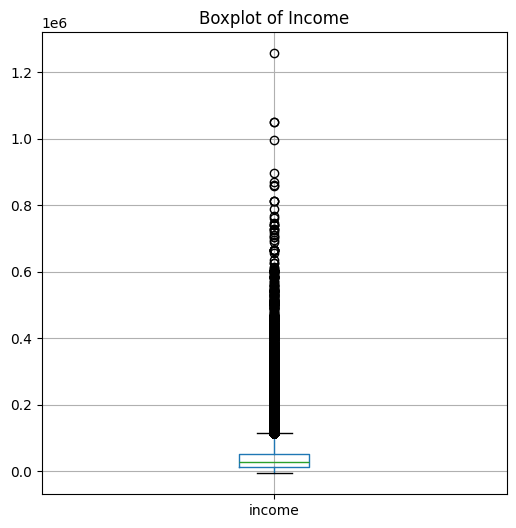

In [13]:
df.boxplot(column="income", figsize=(6,6))
plt.title('Boxplot of Income')
plt.show()

It shows a high number of outliers because of it's high concentration near the lower values (not a normal distribution).

In [14]:
print("Skewness:", df["income"].skew())
print("Kurtosis:", df["income"].kurtosis())

Skewness: 4.851249584109513
Kurtosis: 37.56168753204299


Left-skewness and very high kurtosis indicate transformations are needed before modeling.

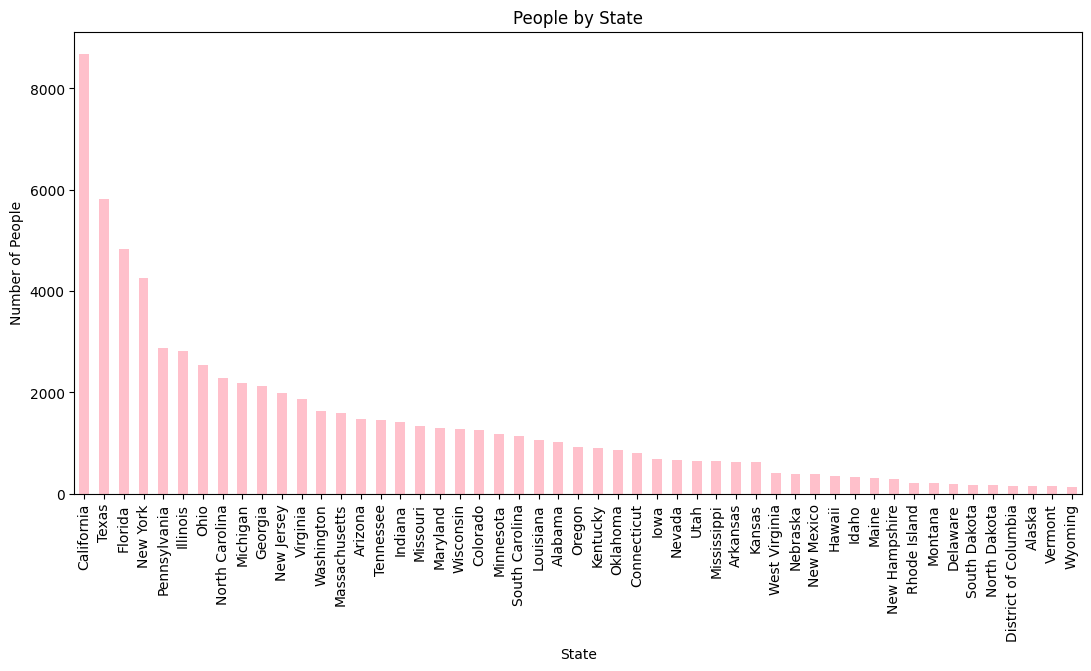

In [15]:
# Where do they live?

state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(13, 6))
state_counts.plot(kind='bar', color='pink')
plt.title('People by State')
plt.xlabel('State')
plt.ylabel('Number of People')
plt.show()

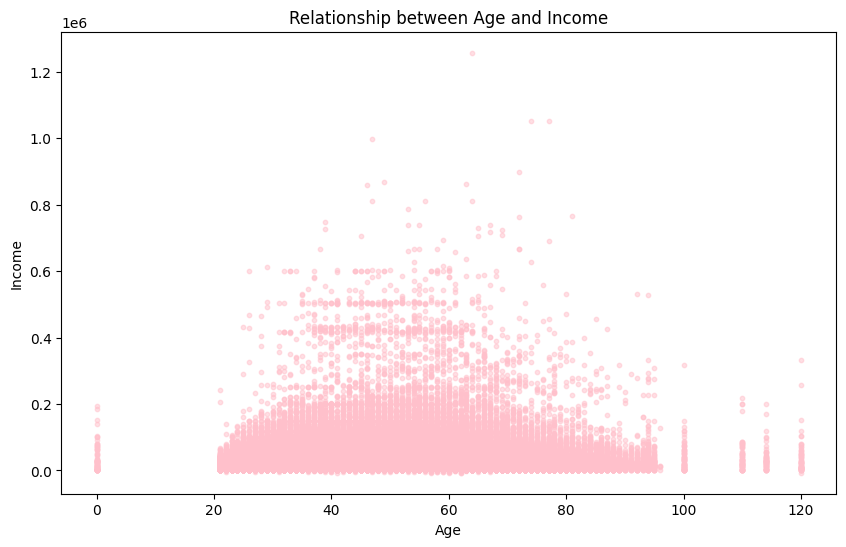

In [16]:
# What is the relation between age and income?

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['income'], alpha=0.5, s=10, color='pink')  
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

(Como se pode ver no gráfico, há claros outliers na idade mas fora isso vemos que o income tem o seu peak na middle age (30-60) e mais baixos em pessoas mais velhas e mais novas que esse intervalo)

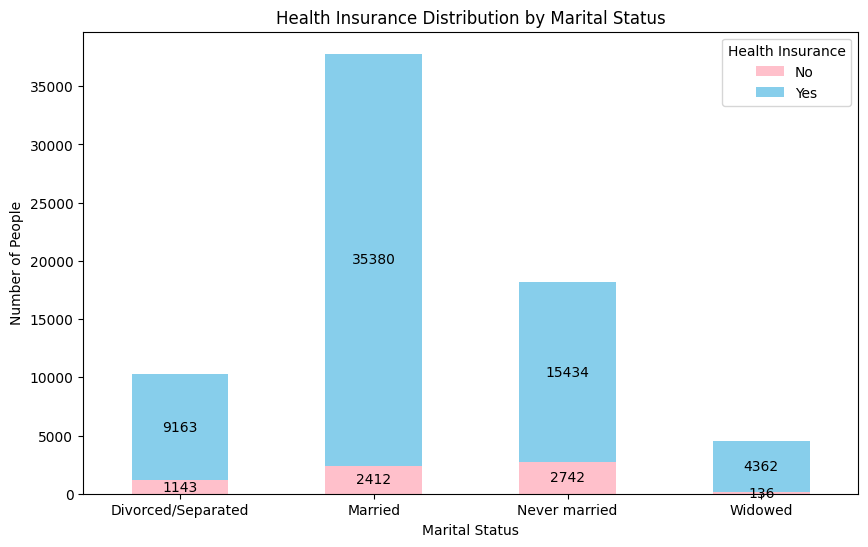

health_ins              False      True 
marital_status                          
Divorced/Separated  11.090627  88.909373
Married              6.382303  93.617697
Never married       15.085827  84.914173
Widowed              3.023566  96.976434


In [17]:
#How the health insurance distributes according to the marital status?

health_counts = df.groupby(['marital_status', 'health_ins']).size().unstack()
ax = health_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['pink', 'skyblue'])

# Add labels to each bar segment
for container in ax.containers:
    ax.bar_label(container, label_type='center')  

# Customize plot
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])  
plt.xticks(rotation=0)  
plt.show()

# Percentages

print(health_counts.div(health_counts.sum(axis=1), axis=0) * 100)

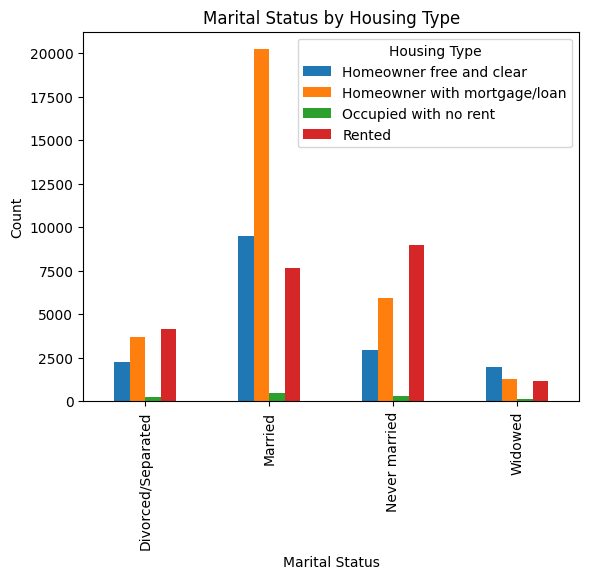

In [18]:
#Visualize the marital status according to the housing type 

marital_housing_counts = pd.crosstab(df['marital_status'], df['housing_type'])
marital_housing_counts.plot(kind='bar', stacked=False)
plt.title("Marital Status by Housing Type")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.legend(title="Housing Type")
plt.show()

             count          mean           std     min      25%      50%  \
age_group                                                                  
<25         6325.0  17870.236838  19152.237581 -5800.0   4300.0  13500.0   
25-34      13105.0  36652.213659  40669.306471 -5500.0  12000.0  29900.0   
35-49      18408.0  51488.357616  66424.568997 -6700.0  14200.0  35000.0   
50-64      18944.0  50419.020323  68862.305690 -6800.0  12000.0  32000.0   
65+        13727.0  37185.322066  54261.527828 -5500.0  11900.0  22000.0   

               75%        max  
age_group                      
<25        25000.0   433000.0  
25-34      50000.0   611000.0  
35-49      65000.0   997000.0  
50-64      62200.0  1257000.0  
65+        42300.0  1051000.0  
          count          mean           std     min      25%      50%  \
sex                                                                     
Female  36896.0  31658.612289  40588.002240 -6800.0   8600.0  20500.0   
Male    33876.0  54582.8

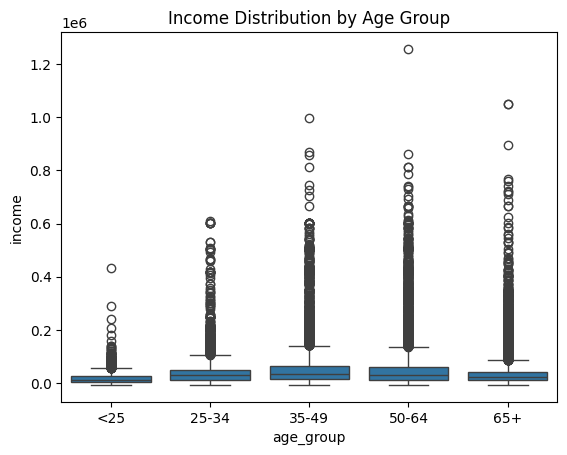

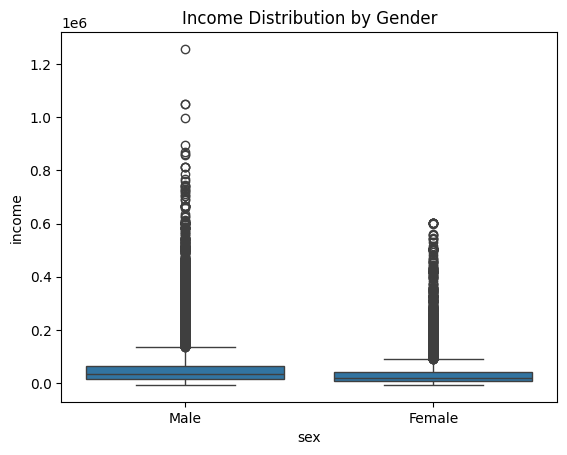

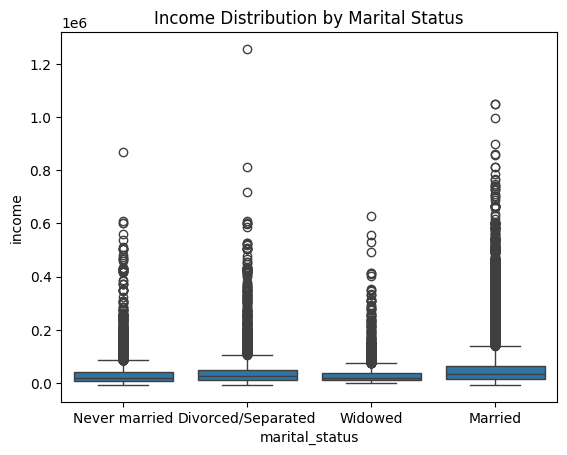

In [19]:
# Do you see differences in the income related to age, gender or the marital situation?

# Comparing incomes: 
# Income statistics by age
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=['<25', '25-34', '35-49', '50-64', '65+'])
print(df.groupby('age_group', observed=True)['income'].describe())

# Income statistics by gender
print(df.groupby('sex')['income'].describe())

# Income statistics by marital status
print(df.groupby('marital_status')['income'].describe())

# Visualizing income differences:
# Income vs. Age
sns.boxplot(x='age_group', y='income', data=df)
plt.title("Income Distribution by Age Group")
plt.show()

# clean new column
df = df.drop(columns=["age_group"])

# Income vs. Gender
sns.boxplot(x='sex', y='income', data=df)
plt.title("Income Distribution by Gender")
plt.show()

# Income vs. Marital Status
sns.boxplot(x='marital_status', y='income', data=df)
plt.title("Income Distribution by Marital Status")
plt.show()

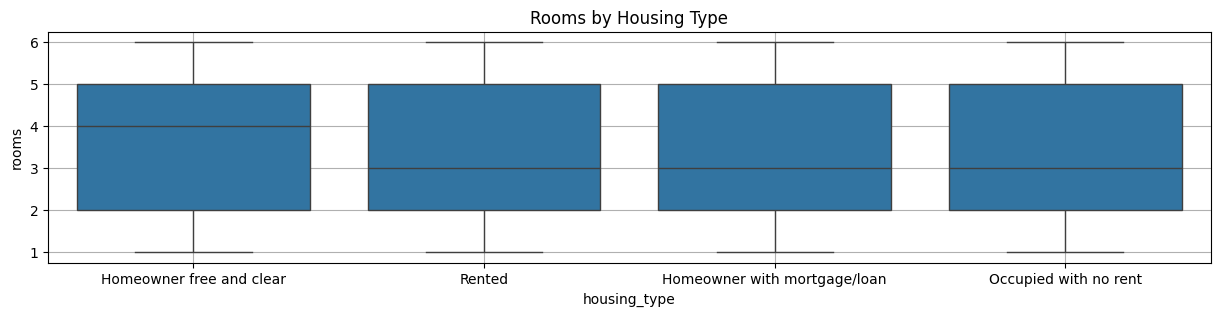

In [20]:
# Rooms by Housing Type
plt.figure(figsize=(15, 3))
sns.boxplot(x='housing_type', y='rooms', data=df)
plt.title("Rooms by Housing Type")
plt.grid()
plt.show()

Owned houses have more rooms (median is 4) than the others (median 3).

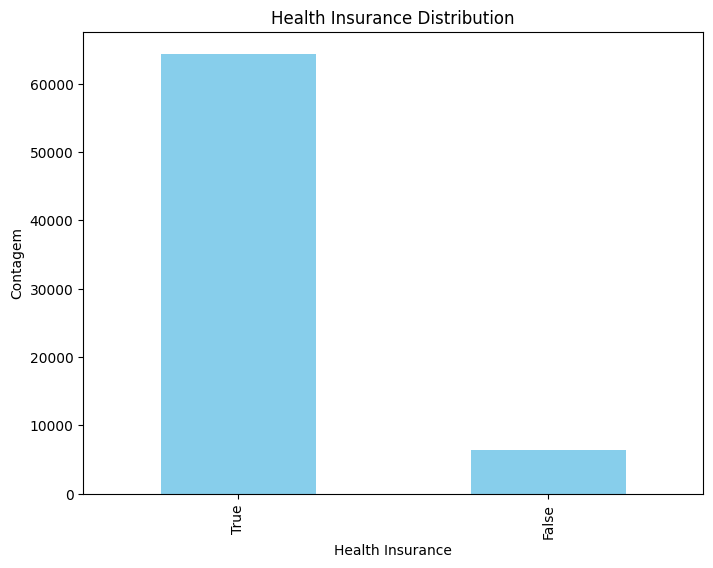

health_ins
True     64339
False     6433
Name: count, dtype: int64


In [21]:
health_ins_distribution = df['health_ins'].value_counts()

plt.figure(figsize=(8, 6))
health_ins_distribution.plot(kind='bar', color='skyblue')
plt.title('Health Insurance Distribution')
plt.xlabel('Health Insurance')
plt.ylabel('Contagem')
plt.show()

print(health_ins_distribution)

### Dropping and One-hot encoding

In [22]:
# Drop unnamed
df = df.drop(columns=['Unnamed: 0'])

# Drop custid and code_column
df = df.drop(columns=['custid', 'code_column'])
# code_column corresponds to state

df['is_employed'] = df['is_employed'].map({False: "unemployed", True: "employed"})
df['is_employed'] = df['is_employed'].fillna("not_in_workforce")

df['num_vehicles'] = df['num_vehicles'].astype(int)

df['gas_usage'] = df['gas_usage'].astype(int)
df['gas_usage'] = df['gas_usage'].replace([1, 2, 3], 0)

In [23]:
def encoding(df):
    df = pd.get_dummies(df, columns=['sex'], drop_first=True)

    df['recent_move_b'] = df['recent_move_b'].map({'F': 0, 'T': 1})

    # One-hot encoding
    df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)
    df = pd.get_dummies(df, columns=['housing_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['state_of_res'], drop_first=True)
    df = pd.get_dummies(df, columns=['is_employed'], drop_first=True)

    df = df.replace({True: 1, False: 0}).infer_objects(copy=False)
    
    return df

/tmp/ipykernel_27595/110884052.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0}).infer_objects(copy=False)


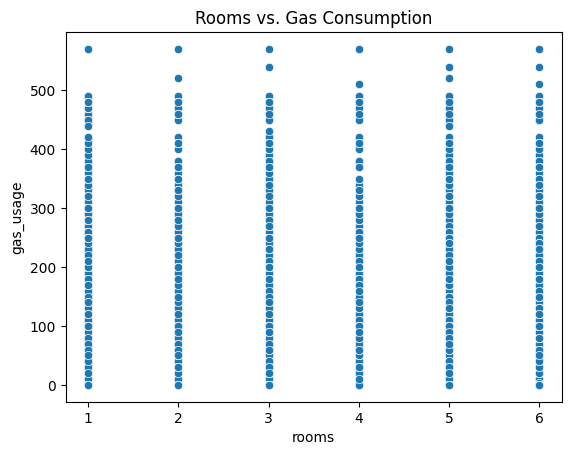

,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,gas_usage,rooms
housing_type_Homeowner with mortgage/loan,1.000000,-0.112249,-0.593655,0.116857,-0.003992
housing_type_Occupied with no rent,-0.112249,1.000000,-0.085043,-0.008072,-0.000834
housing_type_Rented,-0.593655,-0.085043,1.000000,-0.165388,0.000079
gas_usage,0.116857,-0.008072,-0.165388,1.000000,0.001158
rooms,-0.003992,-0.000834,0.000079,0.001158,1.000000


In [24]:
#Are the characteristics of the housing situation interrelated 
#(e.g. is the number of rooms related to the housing type or gas consumption?)

# Visualizing relationships:
dfc= encoding(df)

sns.scatterplot(x='rooms', y='gas_usage', data=dfc)
plt.title("Rooms vs. Gas Consumption")
plt.show()

# Checking correlations:
housing_corr = dfc[['housing_type_Homeowner with mortgage/loan', 'housing_type_Occupied with no rent', 'housing_type_Rented', 'gas_usage', "rooms"]].corr()
housing_corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


Room is not correlated at all and gas_usage is just a bit with occupied with no rent and rented (less than 0.2).

Since gas_usage is also a numeric column, it's important to check if it is normally distributed or skewed before modeling.

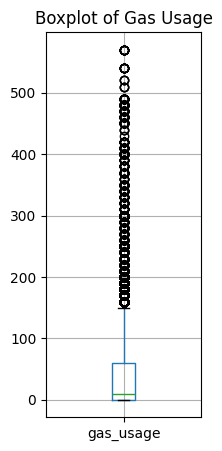

In [25]:
df.boxplot(column="gas_usage", figsize=(2,5))
plt.title('Boxplot of Gas Usage')
plt.show()

The boxplot shows it is skewed and needs handling.

### Data transformation

As it was seen, income and gas_usage are highly skewed and age has some unusual values that need to be handled. Therefore, we apply a logarithmic transformation to the first two and remove the outliers from the first one, since they're most likely wrong values.

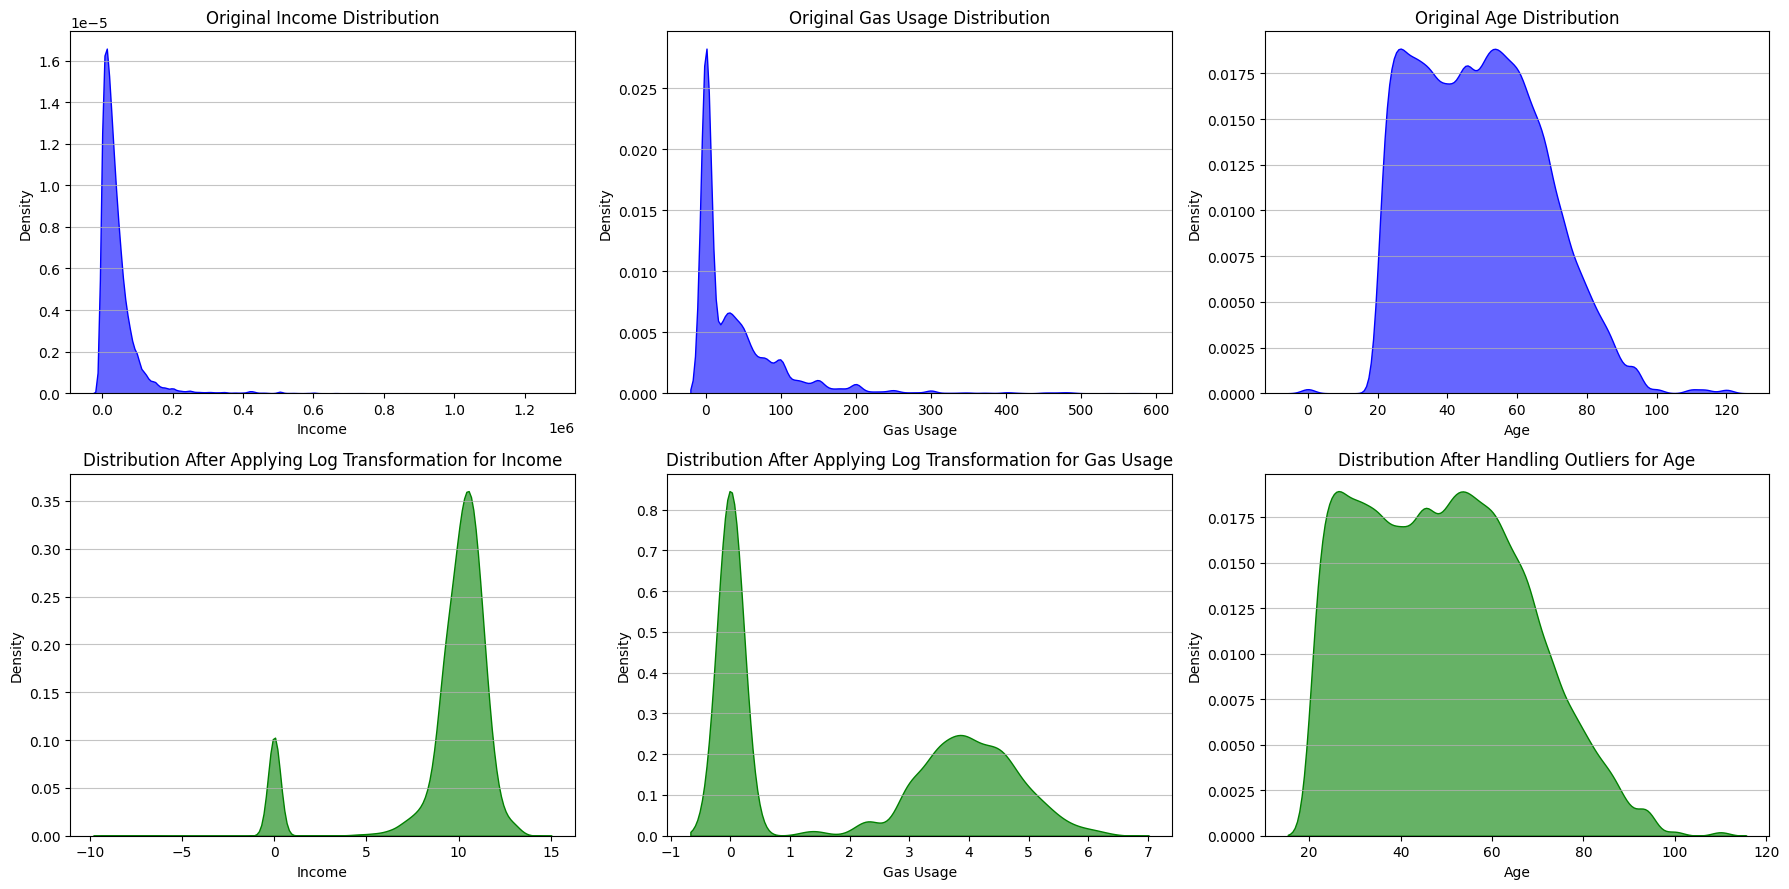

In [26]:
plt.figure(figsize=(18, 9))  

# Before (subplots 1, 2, 3)

plt.subplot(2, 3, 1)
sns.kdeplot(df['income'], fill=True, color='blue', alpha=0.6)
plt.title('Original Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 2)
sns.kdeplot(df['gas_usage'], fill=True, color='blue', alpha=0.6)
plt.title('Original Gas Usage Distribution')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 3)
sns.kdeplot(df['age'], fill=True, color='blue', alpha=0.6)
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Handling outliers for income, age, and gas usage
df['income'] = df['income'].apply(
    lambda x: np.log(x) if x > 0 else (-np.log(abs(x)) if x < 0 else 0)
)
#df['income'] = df['income'].where(df['income'] <= 0.1 * 10**6, 0.1 * 10**6)
df = df[(df['age'] != 0) & (df['age'] <= 110)]
df['gas_usage'] = df['gas_usage'].apply(lambda x: np.log(x) if x > 0 else 0)

# After handling outliers (subplots 4, 5, 6)

plt.subplot(2, 3, 4)
sns.kdeplot(df['income'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 5)
sns.kdeplot(df['gas_usage'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Gas Usage')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 6)
sns.kdeplot(df['age'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Handling Outliers for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()  
plt.show()


After removing age outliers, would be interisting to visualize the probability of health insurance by age:

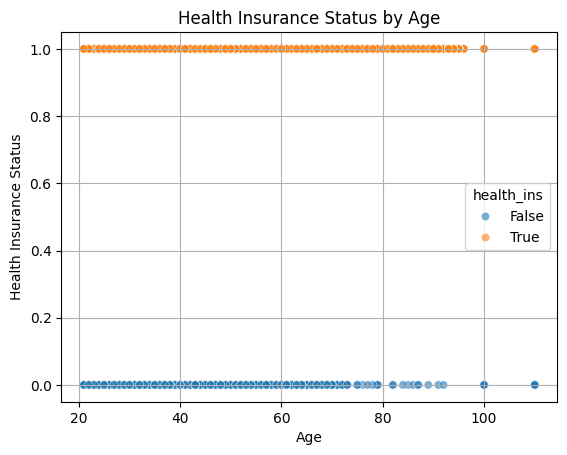

In [27]:
sns.scatterplot(x='age', y='health_ins', data=df, alpha=0.6, hue="health_ins")
plt.xlabel('Age')
plt.ylabel('Health Insurance Status')
plt.title('Health Insurance Status by Age')
plt.grid()
plt.show()

The graph shows there isn't a clear relationship for age and health insurance status, except for a small difference on the older ages where there seem to be more people with insurance than with not.

Now, after applying data transformations, let's encode all the categorical variables again and then create the correlation matrix:

In [28]:
dfc = encoding(df)
correlation_matrix = dfc.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

/tmp/ipykernel_27595/110884052.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0}).infer_objects(copy=False)


,income,health_ins,num_vehicles,age,gas_usage,rooms,recent_move_b,sex_Male,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,state_of_res_Alaska,state_of_res_Arizona,state_of_res_Arkansas,state_of_res_California,state_of_res_Colorado,state_of_res_Connecticut,state_of_res_Delaware,state_of_res_District of Columbia,state_of_res_Florida,state_of_res_Georgia,state_of_res_Hawaii,state_of_res_Idaho,state_of_res_Illinois,state_of_res_Indiana,state_of_res_Iowa,state_of_res_Kansas,state_of_res_Kentucky,state_of_res_Louisiana,state_of_res_Maine,state_of_res_Maryland,state_of_res_Massachusetts,state_of_res_Michigan,state_of_res_Minnesota,state_of_res_Mississippi,state_of_res_Missouri,state_of_res_Montana,state_of_res_Nebraska,state_of_res_Nevada,state_of_res_New Hampshire,state_of_res_New Jersey,state_of_res_New Mexico,state_of_res_New York,state_of_res_North Carolina,state_of_res_North Dakota,state_of_res_Ohio,state_of_res_Oklahoma,state_of_res_Oregon,state_of_res_Pennsylvania,state_of_res_Rhode Island,state_of_res_South Carolina,state_of_res_South Dakota,state_of_res_Tennessee,state_of_res_Texas,state_of_res_Utah,state_of_res_Vermont,state_of_res_Virginia,state_of_res_Washington,state_of_res_West Virginia,state_of_res_Wisconsin,state_of_res_Wyoming,is_employed_not_in_workforce,is_employed_unemployed
income,1.000000,0.174906,0.037929,0.093140,0.022208,0.000498,-0.013026,0.177992,0.029309,-0.072964,0.015793,0.083537,-0.035596,-0.076428,0.002975,-0.007729,-0.009087,-0.024223,0.015662,0.014436,-0.000822,0.006537,-0.019333,-0.011486,0.005887,-0.002392,-0.000800,0.005127,0.012725,0.007589,-0.003770,-0.013444,0.007560,0.016626,0.023693,0.000875,0.019883,-0.008593,0.006755,0.007538,0.008458,-0.002510,0.012253,0.007035,-0.009662,-0.001970,-0.007338,0.006812,0.003469,-0.005283,-0.002801,0.014913,0.007283,-0.006197,0.005735,-0.001845,-0.018511,-0.002573,0.012562,0.010958,0.007434,0.001657,0.017688,0.005601,-0.439849,-0.155837
health_ins,0.174906,1.000000,0.036366,0.168379,0.054463,-0.006142,-0.058678,-0.047102,0.100770,-0.122682,0.055048,0.107671,-0.030076,-0.148064,-0.017662,-0.000266,0.003776,0.012700,0.006542,0.016339,0.003429,0.007893,-0.039245,-0.031562,0.017025,-0.002507,0.014586,-0.000080,0.015558,0.001787,0.011217,-0.012463,0.002570,0.011549,0.032188,0.024873,0.022053,-0.012078,-0.001789,0.001976,-0.006795,-0.006338,0.004451,0.008177,-0.001267,0.021730,-0.022668,0.004873,0.019087,-0.016525,0.006300,0.024146,0.010273,-0.008415,-0.005711,-0.003141,-0.081764,0.002366,0.009803,0.001415,0.013329,0.011407,0.019461,-0.004134,0.047542,-0.099778
num_vehicles,0.037929,0.036366,1.000000,-0.129318,0.119787,-0.001677,-0.119036,0.058573,0.215569,-0.051445,-0.145114,0.280994,-0.040431,-0.315048,0.005543,-0.001890,0.003455,0.063308,0.017578,-0.003990,0.004392,-0.040563,-0.033762,0.004392,0.018749,0.011663,-0.016818,0.006396,0.009967,0.019002,0.000856,-0.011044,0.002006,0.000128,-0.024556,-0.004427,0.009799,0.000685,0.001241,0.017490,0.007102,-0.004795,0.009989,-0.012825,0.009378,-0.129603,0.011286,0.003577,-0.003037,-0.000737,0.011589,-0.015169,-0.005143,0.006219,0.009673,0.014993,0.017555,0.029904,-0.003655,0.020455,0.017738,-0.006747,0.007728,0.006756,-0.163596,-0.024378
age,0.093140,0.168379,-0.129318,1.000000,0.044965,-0.002409,-0.214287,-0.041703,0.155183,-0.464590,0.365093,-0.035384,0.003305,-0.254506,-0.013551,0.005933,-0.001507,-0.027912,-0.008899,0.014231,0.006623,-0.009721,0.035785,-0.010632,0.004107,0.003433,-0.003906,-0.003705,0.011105,0.000867,0.005746,-0.007984,0.014146,0.002066,0.003603,0.006128,0.002492,0.005361,-0.001490,0.007563,-0.001159,-0.004110,0.008023,0.004373,0.001595,0.002458,-0.003114,-0.002751,0.009743,-0.001769,0.005130,0.012932,-0.000143,0.002304,0.006104,0.011740,-0.032534,-0.020884,0.007232,0.001024,-0.006754,0.010170,0.003067,-0.004139,0.468659,-0.098757
gas_usage,0.022208,0.054463,0.119787,0.044965,1.

From that we conclude there are no two features with high enough correlation with another to make us drop it.

Looking at the health_ins column we can decide to drop some features that show really low correlation, since they might not be very usefull for predicting the target variable.

In [29]:
dfc = dfc.drop(dfc.columns[dfc.columns.str.startswith('state')], axis=1)
dfc = dfc.drop(columns=["rooms"])
correlation_matrix = dfc.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,income,health_ins,num_vehicles,age,gas_usage,recent_move_b,sex_Male,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_not_in_workforce,is_employed_unemployed
income,1.000000,0.174906,0.037929,0.093140,0.022208,-0.013026,0.177992,0.029309,-0.072964,0.015793,0.083537,-0.035596,-0.076428,-0.439849,-0.155837
health_ins,0.174906,1.000000,0.036366,0.168379,0.054463,-0.058678,-0.047102,0.100770,-0.122682,0.055048,0.107671,-0.030076,-0.148064,0.047542,-0.099778
num_vehicles,0.037929,0.036366,1.000000,-0.129318,0.119787,-0.119036,0.058573,0.215569,-0.051445,-0.145114,0.280994,-0.040431,-0.315048,-0.163596,-0.024378
age,0.093140,0.168379,-0.129318,1.000000,0.044965,-0.214287,-0.041703,0.155183,-0.464590,0.365093,-0.035384,0.003305,-0.254506,0.468659,-0.098757
gas_usage,0.022208,0.054463,0.119787,0.044965,1.000000,-0.089366,-0.003539,0.081730,-0.053624,-0.011291,0.149829,-0.022290,-0.210803,-0.006361,-0.012155
recent_move_b,-0.013026,-0.058678,-0.119036,-0.214287,-0.089366,1.000000,0.002796,-0.088147,0.113431,-0.049833,-0.159418,0.003635,0.308278,-0.078355,0.030624
sex_Male,0.177992,-0.047102,0.058573,-0.041703,-0.003539,0.002796,1.000000,0.046469,0.065634,-0.137087,0.013653,0.003472,-0.005824,-0.125052,0.013390
marital_status_Married,0.029309,0.100770,0.215569,0.155183,0.081730,-0.088147,0.046469,1.000000,-0.629490,-0.278652,0.206258,-0.028541,-0.250731,-0.005771,-0.072867
marital_status_Never married,-0.072964,-0.122682,-0.051445,-0.464590,-0.053624,0.113431,0.065634,-0.629490,1.000000,-0.153089,-0.134028,0.008944,0.234533,-0.142916,0.090203
marital_status_Widowed,0.015793,0.055048,-0.145114,0.365093,-0.011291,-0.049833,-0.137087,-0.278652,-0.153089,1.000000,-0.084229,0.014415,-0.027338,0.248863,-0.032417


### Summary of Preprocessing: Final Dataset

After the preprocessing, this is our final dataset:

In [30]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70573 entries, 0 to 72456
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   income                                     70573 non-null  float64
 1   health_ins                                 70573 non-null  int64  
 2   num_vehicles                               70573 non-null  int64  
 3   age                                        70573 non-null  int64  
 4   gas_usage                                  70573 non-null  float64
 5   recent_move_b                              70573 non-null  int64  
 6   sex_Male                                   70573 non-null  int64  
 7   marital_status_Married                     70573 non-null  int64  
 8   marital_status_Never married               70573 non-null  int64  
 9   marital_status_Widowed                     70573 non-null  int64  
 10  housing_type_Homeowner with

It has 70573 and 15 columns. For some models we will apply scalinhg, whenever it is required.

### Data scaling

Function for data scaling:

In [31]:
from sklearn import preprocessing

def scaling(df):
    scaler = preprocessing.StandardScaler()

    # Identificar colunas binárias (valores únicos {0, 1})
    binary_cols = [col for col in df.columns if set(df[col].unique()) == {0, 1}]
    continuous_cols = [col for col in df.columns if col not in binary_cols]

    # Escalar apenas as colunas contínuas
    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    
    # Colunas binárias permanecem inalteradas
    return df_scaled

# Modeling

In the modeling phase, we will compare 6 different models:

- Nearest neighbor
- Bayesian Classifier
- Decision Trees
- Tree ensembles
- Support Vector Machines
- Neural Network Classifier

For each one, we will compare the non-balanced and balanced dataset. For balancing, we will use SMOTE (Synthetic Minority Oversampling Technique), which is a technique that genarates synthetic samples for the minority class. 

First we create a evaluation function to use for each model:

In [32]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

def evaluation(y,y_pred):
    # Scores
    print("classification report: \n", classification_report(y,y_pred))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y, y_pred), 
            annot=True, fmt="d", cmap="Blues", cbar=False, square=True, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)

    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color="blue")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].legend(loc="lower right")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

Then, we define the SMOTE object to be used for the balanced predictions:

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state=42)

Finally, we create a scorer to use on cross-validation for hyperparameter tuning. We use the F1 score since it's a balanced precision/recall criteria and the evaluation metric used on the Kaggle competition. Since we want to predict the clients **without** health-insurance, we consider 0 as the reference.

In [34]:
from sklearn.metrics import f1_score, make_scorer

f1_label_0 = make_scorer(f1_score, pos_label=0, average="binary")

### Baseline Model - Dummy Classifier


To start, we use a dummy classifier to have a baseline metric to compare with the other models.

In [69]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

dfdummy= scaling(dfc)

y = dfdummy["health_ins"]
X = dfdummy.drop(["health_ins"], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

dummy_clf = DummyClassifier(strategy="stratified")  
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label=0)
print(f"F1 of Dummy Classifier: {f1:.2f}")

F1 of Dummy Classifier: 0.15


classification report: 
               precision    recall  f1-score   support

           0       0.09      0.49      0.15      1312
           1       0.91      0.50      0.64     12803

    accuracy                           0.50     14115
   macro avg       0.50      0.50      0.40     14115
weighted avg       0.83      0.50      0.60     14115



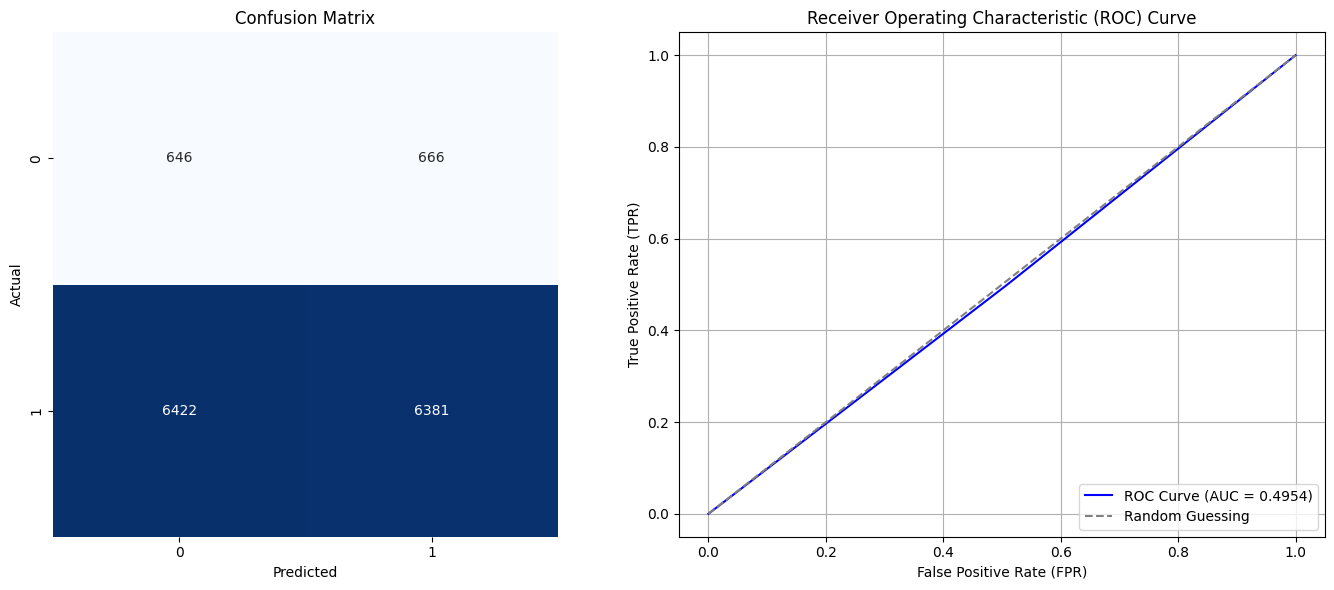

In [70]:
evaluation(y_test,y_pred)

### K-NN

We start by scaling the data with the scaling function to standardize the preprocessed dataset "dfc" and store it in "dfknn". 
The next step it to separate features (X) and target (y), where y is the target variable (health_ins, which we want to predict), and X contains the feature variables (everything except health_ins).

In [37]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [39]:

dfknn= scaling(dfc)

y = dfknn["health_ins"]
X = dfknn.drop(["health_ins"], axis=1) 

Unbalanced:

Here, we create the train_test_split with stratification.
The stratification is made to ensure that the class proportions in the training and testing datasets are the same as in the original dataset, to avoid one class being underrepresented in the split.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Then we use hyperparameter tuning with Grid Search, and fit the grid search to the training data. After fitting, grid_search.best_estimator_.predict() retrieves the best value for n_neighbors (this is the k that performed best during cross-validation), refits the entire train data, and computes the final prediction on the test data with the refitted model.

In [ ]:
param_grid = {'n_neighbors': range(1, 11)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring=f1_label_0,
    cv=skf,  
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {optimal_k}")

y_pred = grid_search.best_estimator_.predict(X_test)

In [44]:
y_pred = grid_search.best_estimator_.predict(X_test)

classification report: 
               precision    recall  f1-score   support

           0       0.19      0.34      0.25      1284
           1       0.93      0.86      0.89     12831

    accuracy                           0.81     14115
   macro avg       0.56      0.60      0.57     14115
weighted avg       0.86      0.81      0.83     14115



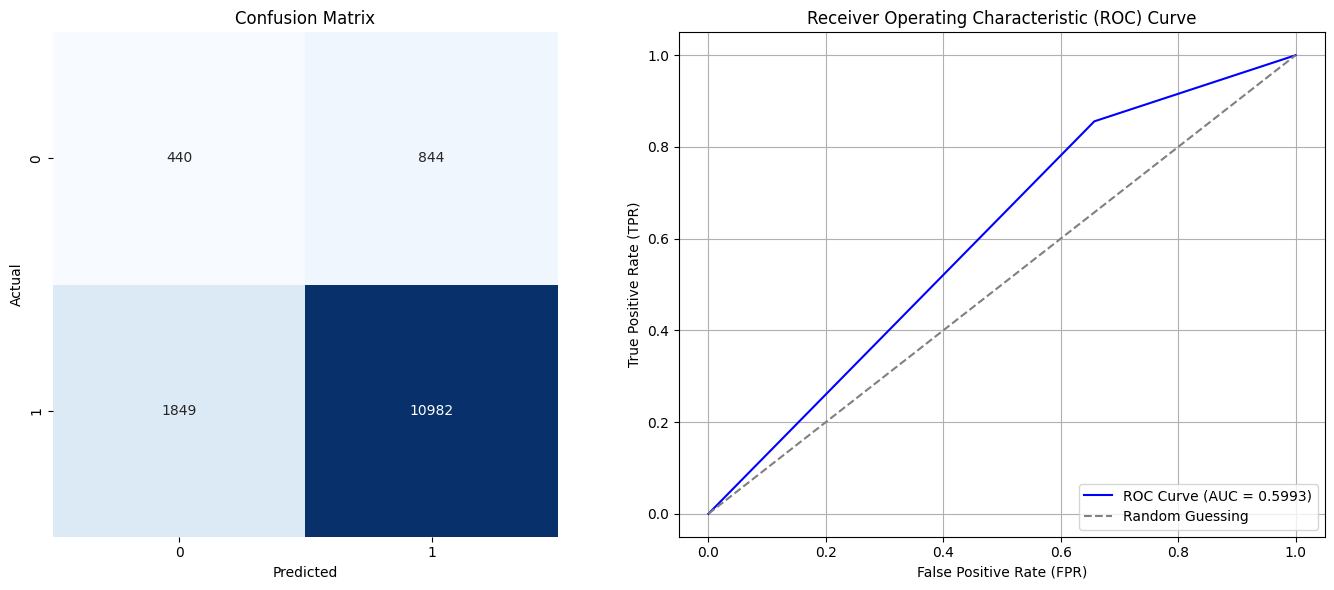

In [45]:
evaluation(y_test,y_pred)

Balanced

A pipeline is created with smote (ensures oversampling happens only on the training folds during cross-validation, avoiding data leakage) and knn classifier. 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
knn = KNeighborsClassifier()
pipeline = Pipeline([('smote', smote), ('classifier', knn)])

param_grid = {'classifier__n_neighbors': range(1, 11)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f1_label_0,
    cv=skf,  
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['classifier__n_neighbors']
print(f"Optimal k: {optimal_k}")

y_pred = grid_search.best_estimator_.predict(X_test)

Optimal k: 9


classification report: 
               precision    recall  f1-score   support

           0       0.18      0.58      0.28      1284
           1       0.95      0.74      0.83     12831

    accuracy                           0.72     14115
   macro avg       0.56      0.66      0.55     14115
weighted avg       0.88      0.72      0.78     14115



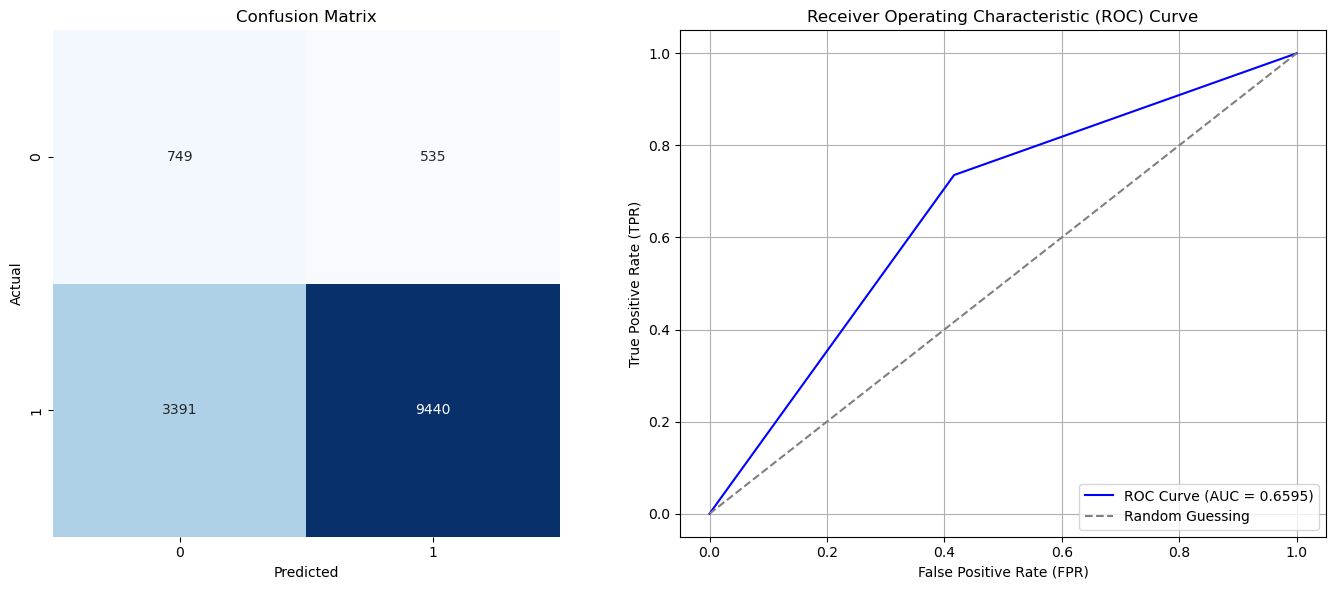

In [43]:
evaluation(y_test,y_pred)

### Predict with Bayesian Classifier


Importing GaussianNB to follow a Gaussian distribution.
We prepare the dataset now reusing the dfknn from the KNN model.
And then features (X) and target (y) are defined.

In [44]:
from sklearn.naive_bayes import GaussianNB

dfbc = dfknn
X = dfbc.drop('health_ins', axis=1)  
y = dfbc['health_ins'] 

Unbalanced

Here, after the train-test split, it is inicialized a Gaussian Naive Bayes classifier.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

classification report: 
               precision    recall  f1-score   support

           0       0.22      0.31      0.26      1284
           1       0.93      0.89      0.91     12831

    accuracy                           0.83     14115
   macro avg       0.57      0.60      0.58     14115
weighted avg       0.86      0.83      0.85     14115



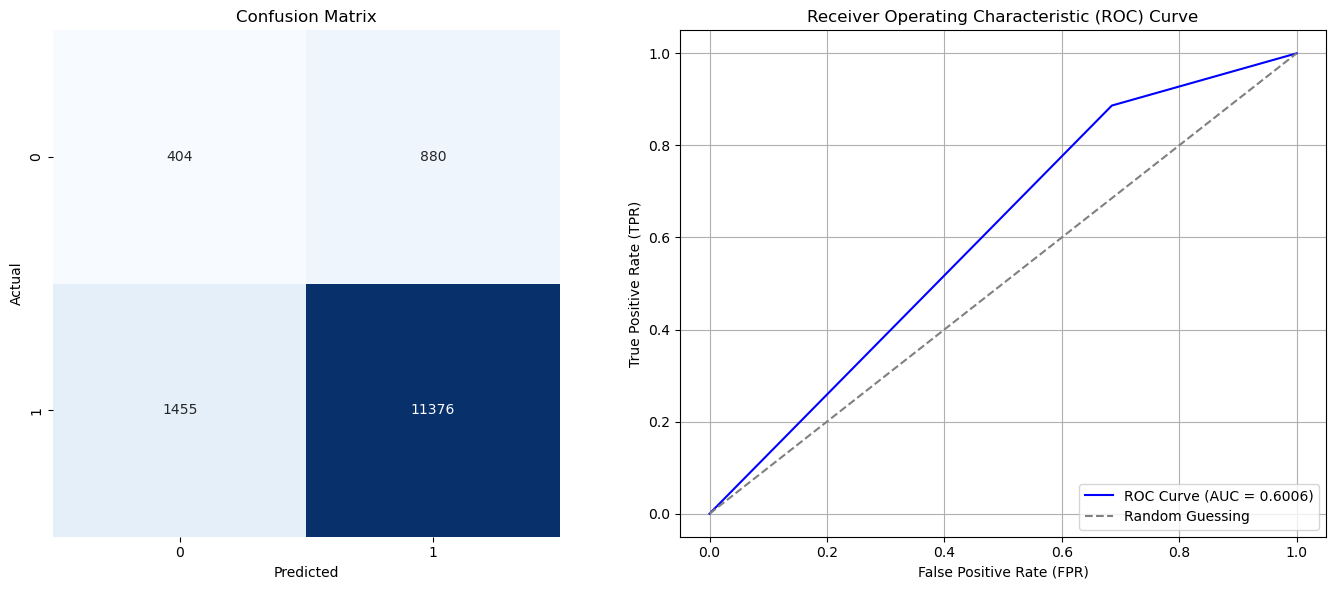

In [46]:
evaluation(y_test,y_pred)

Balanced

After train-test split, the data is balanced with SMOTE, which is integrated into the pipeline to ensure oversampling happens only on the training data during the model fitting process, avoiding data leakage.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
gauss = GaussianNB()
pipeline = Pipeline([('smote', smote), ('classifier', gauss)])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

classification report: 
               precision    recall  f1-score   support

           0       0.17      0.78      0.28      1284
           1       0.97      0.62      0.75     12831

    accuracy                           0.63     14115
   macro avg       0.57      0.70      0.52     14115
weighted avg       0.89      0.63      0.71     14115



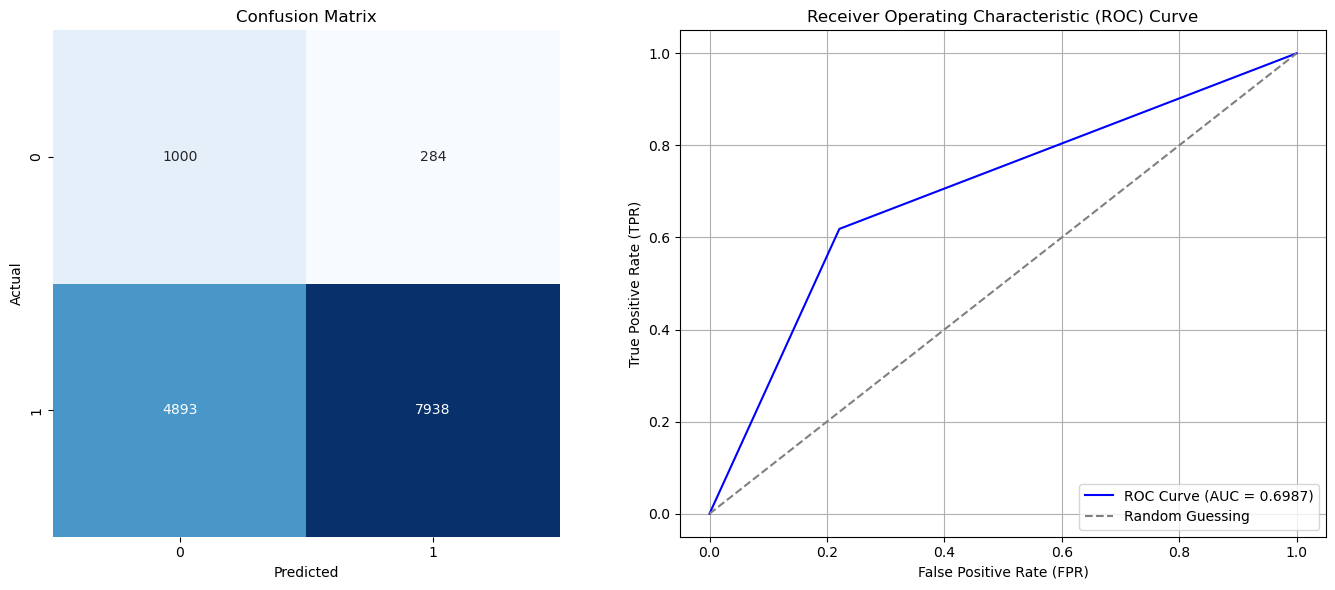

In [48]:
evaluation(y_test,y_pred)

### Decision Trees

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

dftree=dfc

X = dftree.drop('health_ins', axis=1)  
y = dftree['health_ins'] 

Unbalanced

In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, y_train = smote.fit_resample(X_train, y_train)

param_grid = {'max_depth': range(1, 20)}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
mean_f1_scores = grid_search.cv_results_['mean_test_score']
max_depth_values = grid_search.cv_results_['param_max_depth'].data

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 19}


classification report: 
               precision    recall  f1-score   support

           0       0.19      0.50      0.27      1284
           1       0.94      0.79      0.86     12831

    accuracy                           0.76     14115
   macro avg       0.56      0.64      0.57     14115
weighted avg       0.87      0.76      0.80     14115



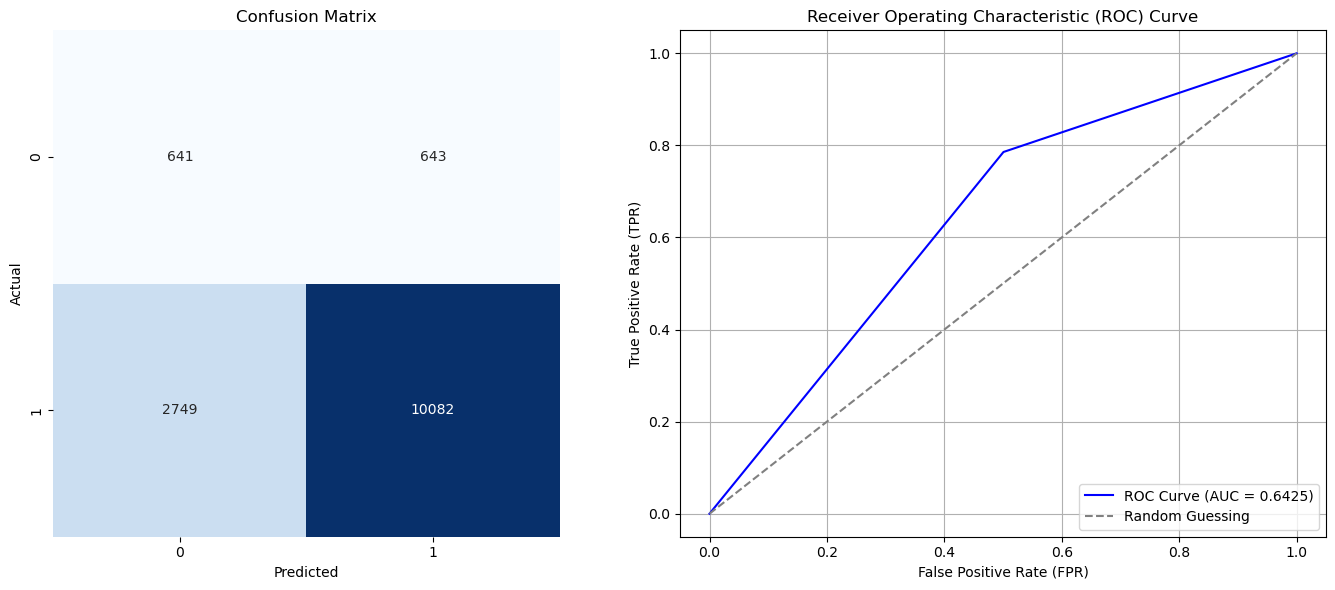

In [51]:
evaluation(y_test,y_pred)

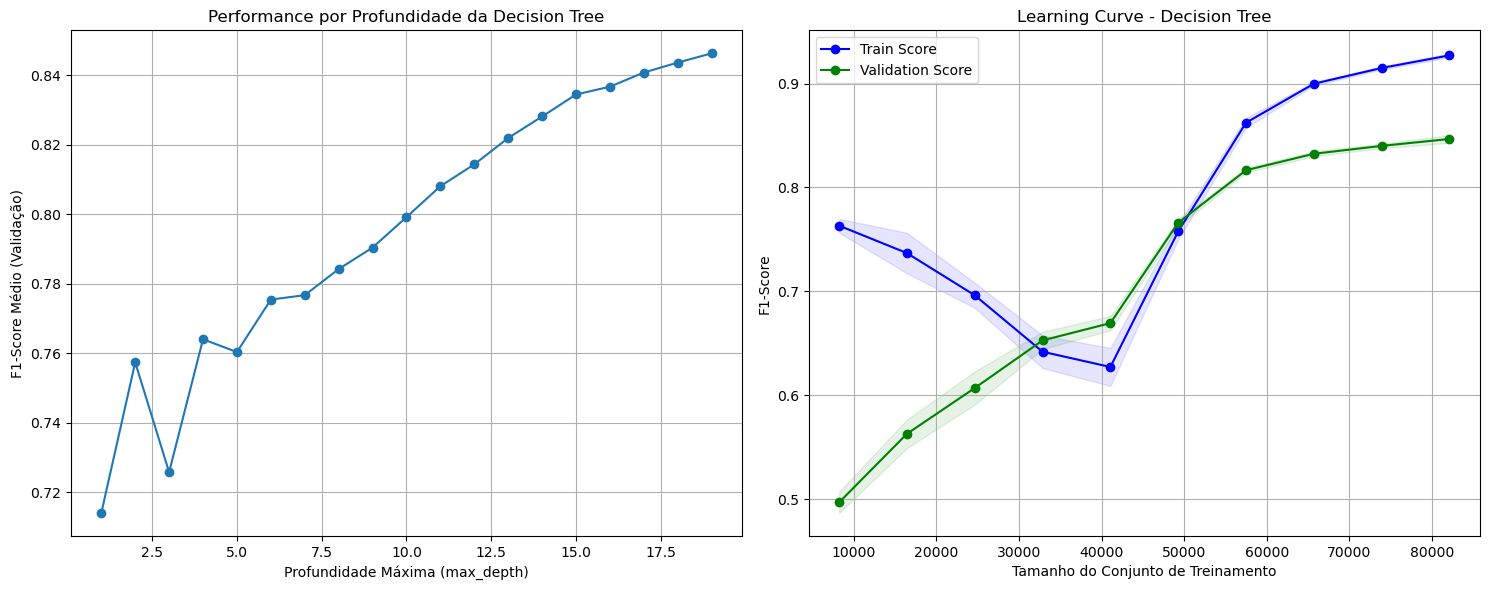

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# Gráfico da performance por profundidade
axs[0].plot(max_depth_values, mean_f1_scores, marker='o')
axs[0].set_xlabel("Profundidade Máxima (max_depth)")
axs[0].set_ylabel("F1-Score Médio (Validação)")
axs[0].set_title("Performance por Profundidade da Decision Tree")
axs[0].grid()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=skf, scoring=f1_label_0, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calcular a média e desvio padrão para cada tamanho de treino
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Learning curve
axs[1].plot(train_sizes, train_scores_mean, label='Train Score', color='blue', marker='o')
axs[1].plot(train_sizes, val_scores_mean, label='Validation Score', color='green', marker='o')

# Áreas de desvio padrão
axs[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axs[1].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')

# Labels
axs[1].set_xlabel("Tamanho do Conjunto de Treinamento")
axs[1].set_ylabel("F1-Score")
axs[1].set_title("Learning Curve - Decision Tree")
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

Balanced

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote= SMOTE(random_state=42)

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
pipeline= Pipeline([('smote',smote),('classifier',dt)])

param_grid = {'classifier__max_depth': range(1, 20)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
mean_f1_scores = grid_search.cv_results_['mean_test_score']
max_depth_values = grid_search.cv_results_['param_classifier__max_depth'].data

print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__max_depth': 7}


classification report: 
               precision    recall  f1-score   support

           0       0.20      0.69      0.31      1284
           1       0.96      0.72      0.82     12831

    accuracy                           0.72     14115
   macro avg       0.58      0.70      0.56     14115
weighted avg       0.89      0.72      0.78     14115



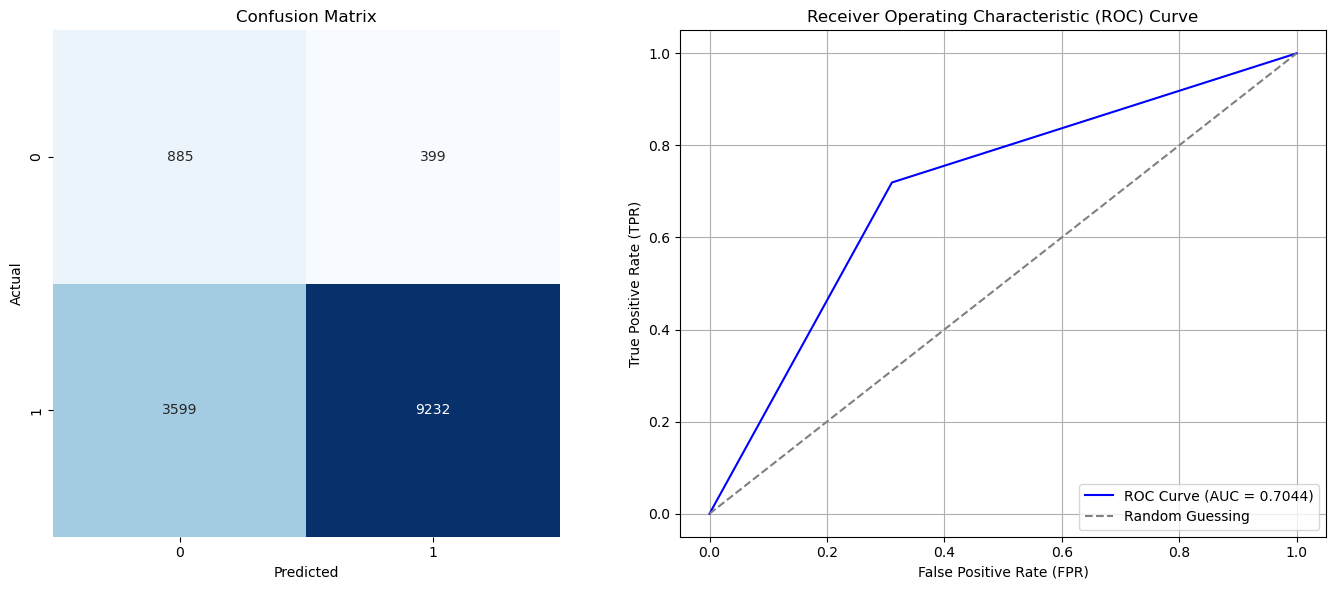

In [54]:
evaluation(y_test,y_pred)

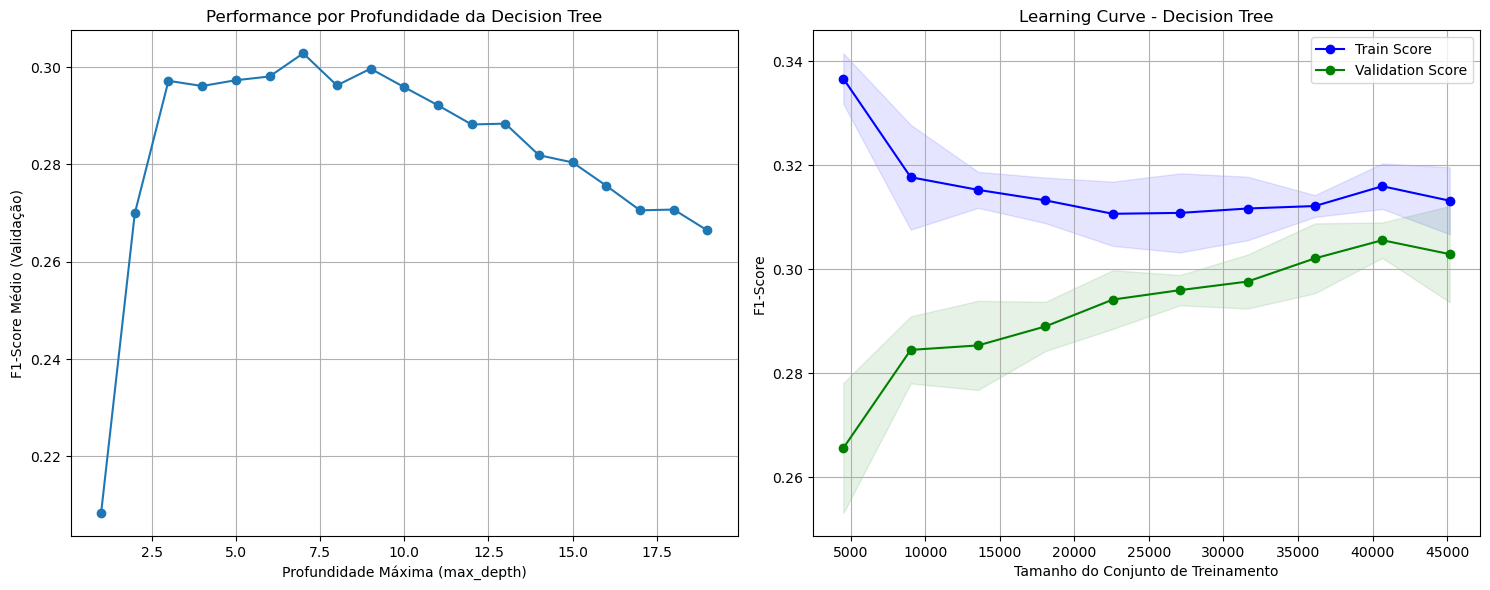

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# Gráfico da performance por profundidade
axs[0].plot(max_depth_values, mean_f1_scores, marker='o')
axs[0].set_xlabel("Profundidade Máxima (max_depth)")
axs[0].set_ylabel("F1-Score Médio (Validação)")
axs[0].set_title("Performance por Profundidade da Decision Tree")
axs[0].grid()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=skf, scoring=f1_label_0, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calcular a média e desvio padrão para cada tamanho de treino
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Learning curve
axs[1].plot(train_sizes, train_scores_mean, label='Train Score', color='blue', marker='o')
axs[1].plot(train_sizes, val_scores_mean, label='Validation Score', color='green', marker='o')

# Áreas de desvio padrão
axs[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axs[1].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')

# Labels
axs[1].set_xlabel("Tamanho do Conjunto de Treinamento")
axs[1].set_ylabel("F1-Score")
axs[1].set_title("Learning Curve - Decision Tree")
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

ANALISE: 

Inicialmente tentamos a decision tree com valores parametros so que os valores do f1 davam sempre muito muito baixos.

Entao pusemos o parametro class_weight='balanced' no classifier para ver se os resultados melhoravam e notou se uma diferença gigante pois antes o AUC tava muito perto do random e agora está mais ou menos a 0.72. Claro que se perdeu bastante accuracy mas aqui como o nosso foco é a classe minoritária, notou se uma evolucao muito boa na avaliacao desta.

De forma a arranjar um valor ideal para o tamanho da arvore pusemos lado a lado um grafico a mostrar o f1 para diferentes valores de profundidade e a learning curve para verificar a perfomance do modelo e ver se nao haver under ou overfitting. Para ambos os casos, a altura ideal da arvore foi =9 pois da nos um modelo com maior f1 e parece estar a generar razoavelmente bem.

Novamente, nao se notou grande diferença entre o estratificado e o sem ser estratificado.

Overall, este modelo é decente apesar de se ter de sacrificar bastante a accuracy para ele funcionar melhor na classificaçao da classe minoritária. 

### Tree Ensembles


In [56]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

dfen = dfc

X = dfen.drop('health_ins', axis=1)  
y = dfen['health_ins'] 

#### RandomForest

Non-stratified e unbalanced

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42,max_depth=10, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 500}


classification report: 
               precision    recall  f1-score   support

           0       0.21      0.77      0.33      1312
           1       0.97      0.70      0.82     12803

    accuracy                           0.71     14115
   macro avg       0.59      0.74      0.57     14115
weighted avg       0.90      0.71      0.77     14115



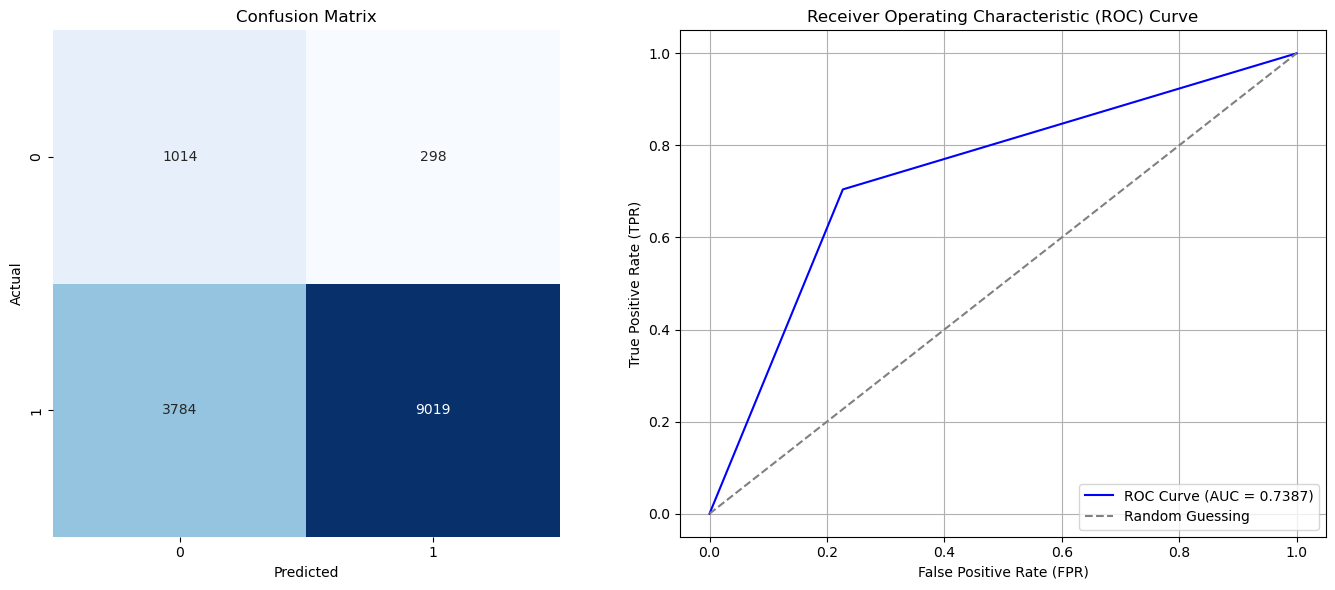

In [58]:
evaluation(y_test, y_pred)

Stratified and unbalanced

We decided to just tune the number of estimators to speed up the process, since the max depth of 9/10 has been shown to be the best for the decision trees and the non stratified Random Forest model.

In [59]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 500}


classification report: 
               precision    recall  f1-score   support

           0       0.21      0.76      0.33      1284
           1       0.97      0.71      0.82     12831

    accuracy                           0.72     14115
   macro avg       0.59      0.73      0.57     14115
weighted avg       0.90      0.72      0.78     14115



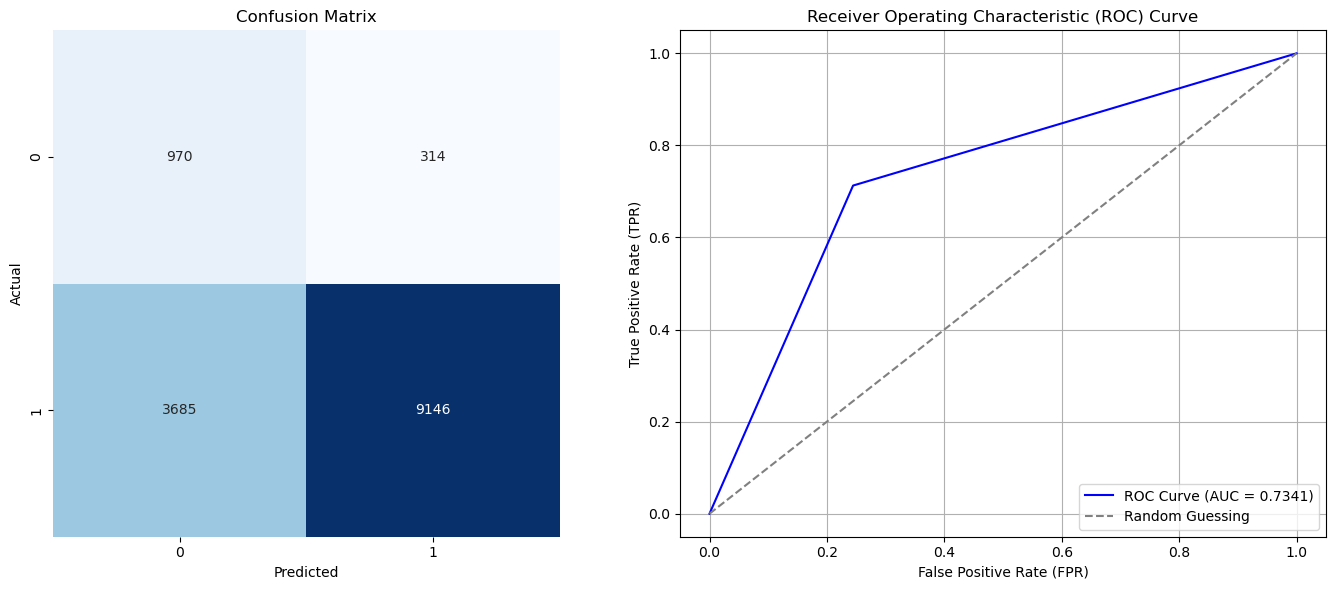

In [60]:
evaluation(y_test, y_pred)

Stratified and Balanced

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)

rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_jobs=-1)
pipeline = Pipeline([('smote', smote), ('classifier', rf)])

param_grid = {
    'classifier__n_estimators': [100, 200, 500]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=skf,scoring=f1_label_0,n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__n_estimators': 200}


classification report: 
               precision    recall  f1-score   support

           0       0.21      0.67      0.32      1284
           1       0.96      0.74      0.84     12831

    accuracy                           0.74     14115
   macro avg       0.58      0.71      0.58     14115
weighted avg       0.89      0.74      0.79     14115



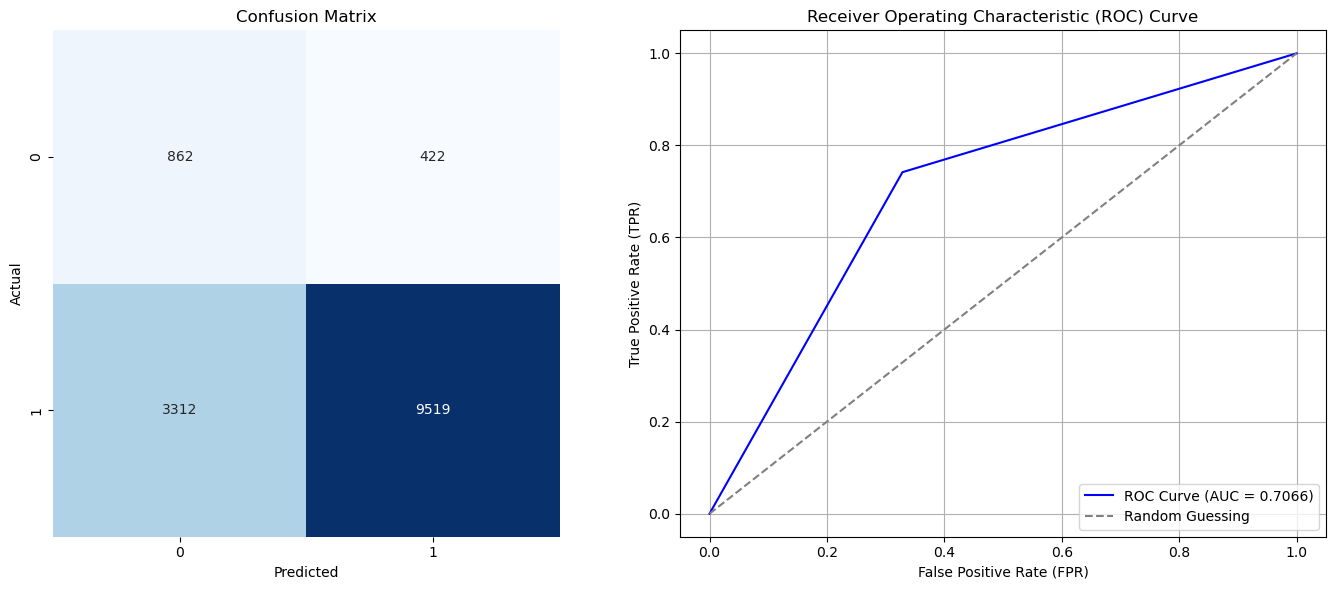

In [62]:
evaluation(y_test, y_pred)

#### XGBoost

Unbalanced

In [63]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500]
}

negative_samples = sum(y_train == 0)
positive_samples = sum(y_train == 1)
scale_pos_weight = negative_samples / positive_samples

xg = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 100}


classification report: 
               precision    recall  f1-score   support

           0       0.21      0.76      0.33      1284
           1       0.97      0.71      0.82     12831

    accuracy                           0.72     14115
   macro avg       0.59      0.74      0.57     14115
weighted avg       0.90      0.72      0.78     14115



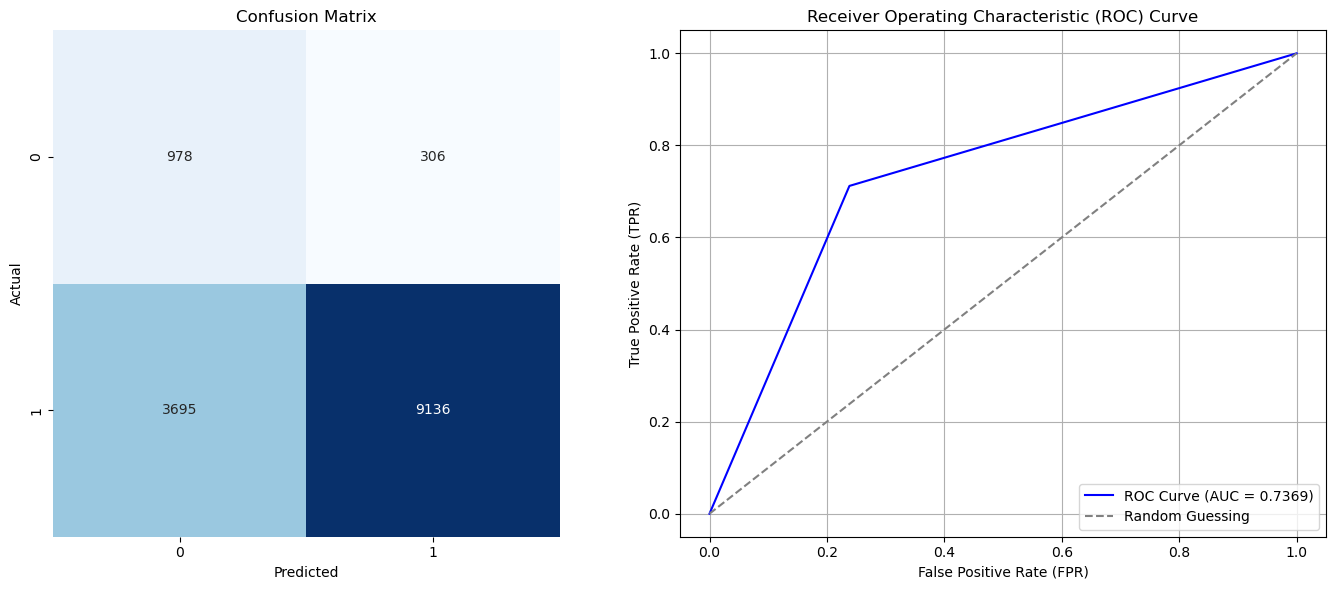

In [64]:
evaluation(y_test, y_pred)

Balanced

In [65]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote= SMOTE(random_state=42)

negative_samples = sum(y_train == 0)
positive_samples = sum(y_train == 1)
scale_pos_weight = negative_samples / positive_samples

xg = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
pipeline= Pipeline([('smote',smote),('classifier',xg)])

param_grid = {'classifier__n_estimators': [100, 200, 500]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__n_estimators': 500}


classification report: 
               precision    recall  f1-score   support

           0       0.17      0.75      0.28      1284
           1       0.96      0.63      0.76     12831

    accuracy                           0.65     14115
   macro avg       0.57      0.69      0.52     14115
weighted avg       0.89      0.65      0.72     14115



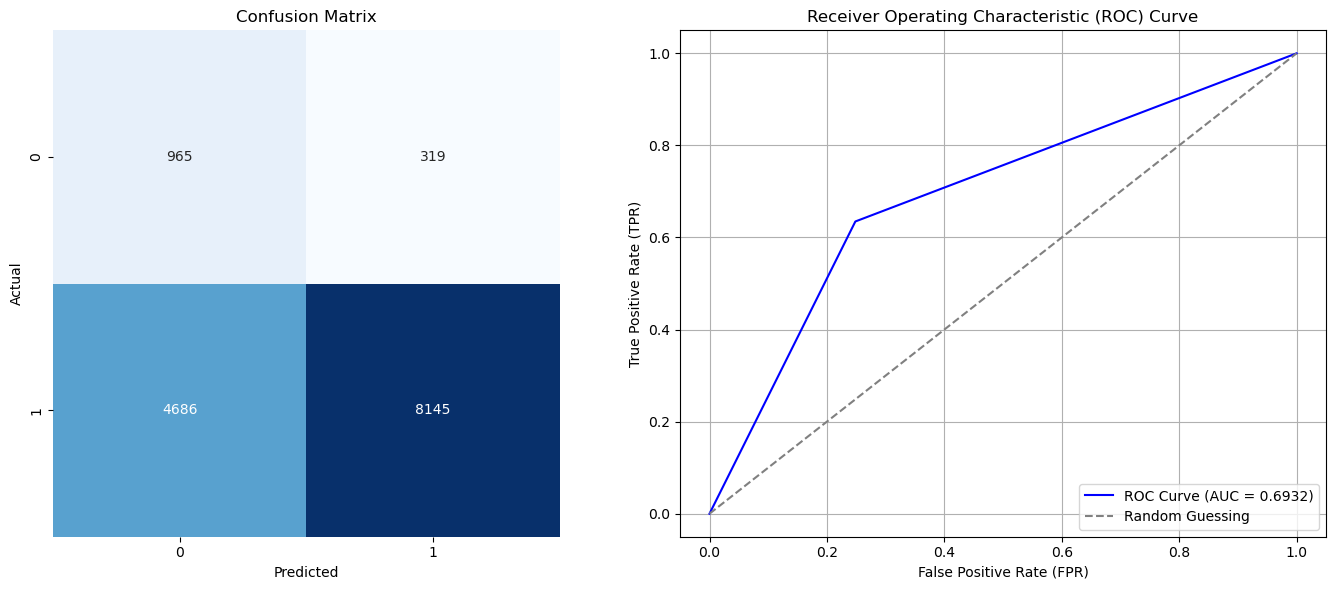

In [66]:
evaluation(y_test, y_pred)

### SVM

For an SVM, here again we scale the data and do feature and target sepatation.

In [67]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

dfsvm = scaling(dfc)

X = dfsvm.drop('health_ins', axis=1)
y = dfsvm['health_ins']

Unbalanced

For the data splitting, it is used the StratifiedKFold and then the test-train split.
In the next step is the hyperparameter grid, which specifies different values of the regularization parameter C to test.
C controls the trade-off between maximizing the margin and minimizing classification errors.

In [68]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    "C": [0.01, 0.1, 1, 10, 100]
}

Now for the model setup: A linear Support Vector Machine classifier.
The class_weight="balanced" utomatically adjusts the weights of each class inversely proportional to their frequencies, helping to handle the imbalance.

In [69]:
svm = LinearSVC(random_state=42, class_weight="balanced")
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_dist, 
    scoring=f1_label_0,
    cv=skf, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_svm.predict(X_test)


Best parameters: {'C': 0.1}


classification report: 
               precision    recall  f1-score   support

           0       0.19      0.75      0.30      1284
           1       0.96      0.68      0.80     12831

    accuracy                           0.69     14115
   macro avg       0.58      0.71      0.55     14115
weighted avg       0.89      0.69      0.75     14115



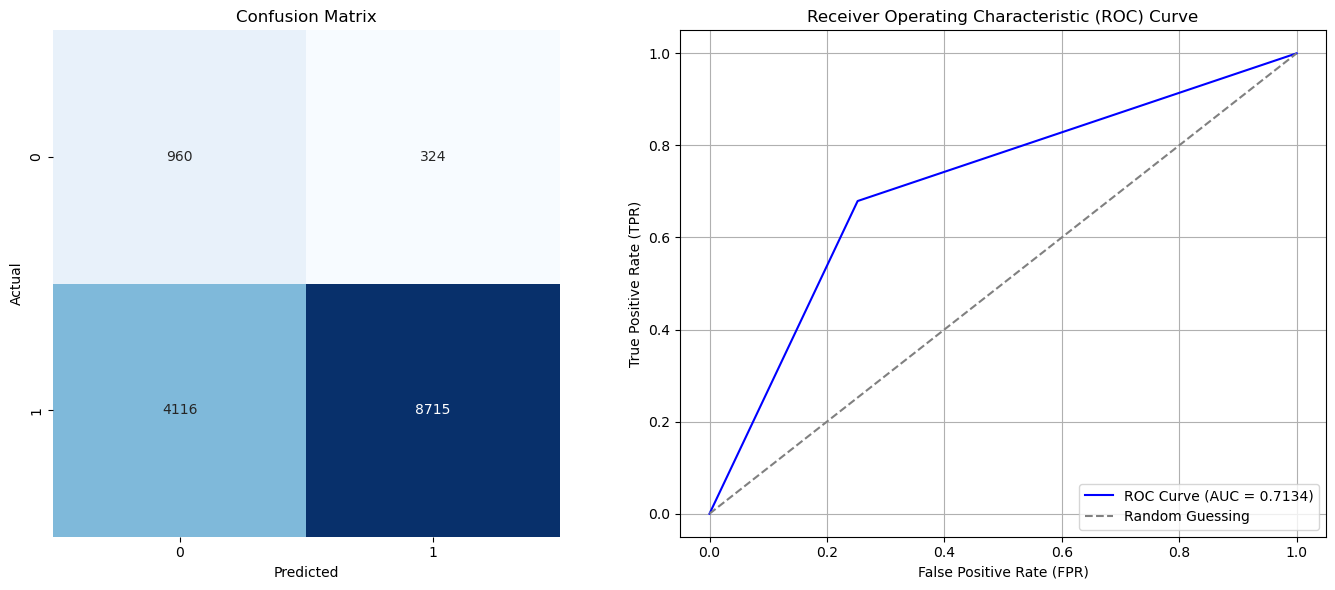

In [70]:
evaluation(y_test, y_pred)

Balanced

For balanced data, SMOTE actively balances the training data by creating synthetic samples, ensuring both classes are equally represented during training.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote= SMOTE(random_state=42)

svm = LinearSVC(random_state=42, class_weight="balanced")
pipeline= Pipeline([('smote',smote),('classifier',svm)])

param_dist = {
    "classifier__C": [0.01, 0.1, 1, 10, 100]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_dist, 
    scoring=f1_label_0,
    cv=skf, 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_svm.predict(X_test)

Best parameters: {'classifier__C': 0.01}


classification report: 
               precision    recall  f1-score   support

           0       0.19      0.75      0.30      1284
           1       0.96      0.67      0.79     12831

    accuracy                           0.68     14115
   macro avg       0.57      0.71      0.54     14115
weighted avg       0.89      0.68      0.75     14115



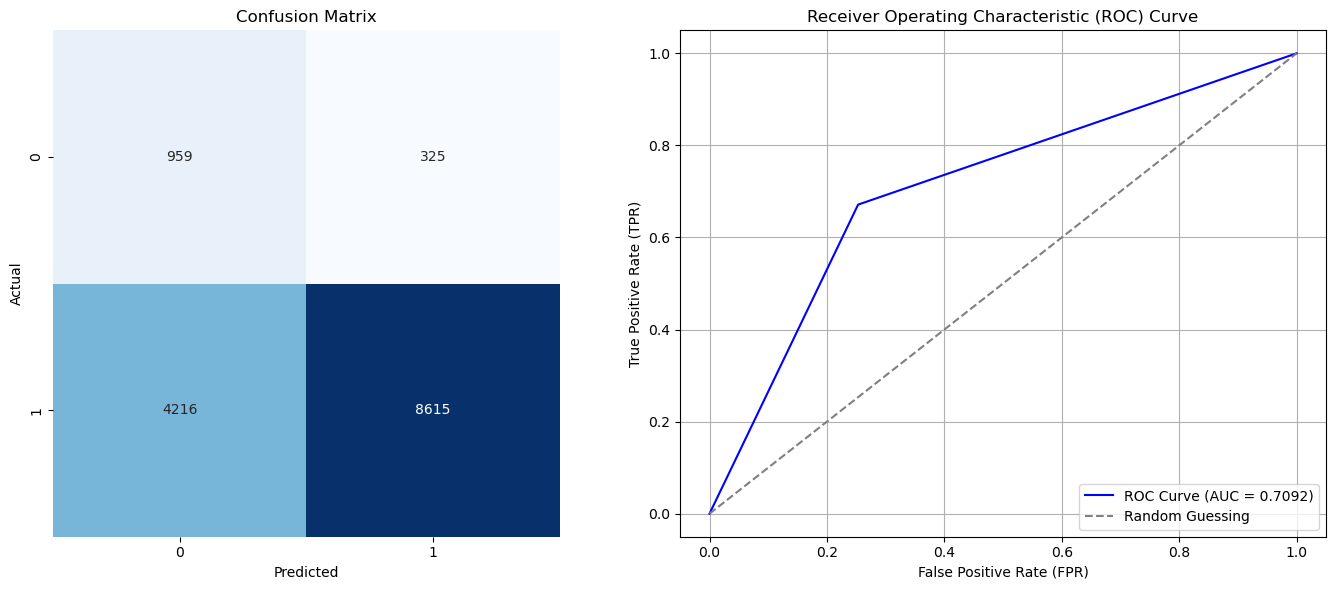

In [72]:
evaluation(y_test, y_pred)

### Neural Networks

In [68]:
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.model_selection import RandomizedSearchCV

dfnn = scaling(dfc)

X = dfnn.drop('health_ins', axis=1)
y = dfnn['health_ins'] 

Unbalanced

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

mlp = MLPClassifier(random_state=42, max_iter=500)

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32, 32), (64, 64)],  
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'alpha': [0.0001, 0.001],                                 
    'learning_rate': ['constant', 'adaptive']                 
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, scoring=f1_label_0, cv=skf, n_jobs=-1, random_state=42)

grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
print("Best parameters:", grid_search.best_params_)

joblib.dump(grid_search.best_estimator_, 'unbalanced_nn.joblib')

/home/barbara/MDS/IDS/IDS_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/barbara/MDS/IDS/IDS_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/barbara/MDS/IDS/IDS_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/barbara/MDS/IDS/IDS_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the o

Best parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (64, 64), 'alpha': 0.0001, 'activation': 'tanh'}


/home/barbara/MDS/IDS/IDS_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


['unbalanced_nn.joblib']

classification report: 
               precision    recall  f1-score   support

           0       0.28      0.13      0.18      1284
           1       0.92      0.97      0.94     12831

    accuracy                           0.89     14115
   macro avg       0.60      0.55      0.56     14115
weighted avg       0.86      0.89      0.87     14115



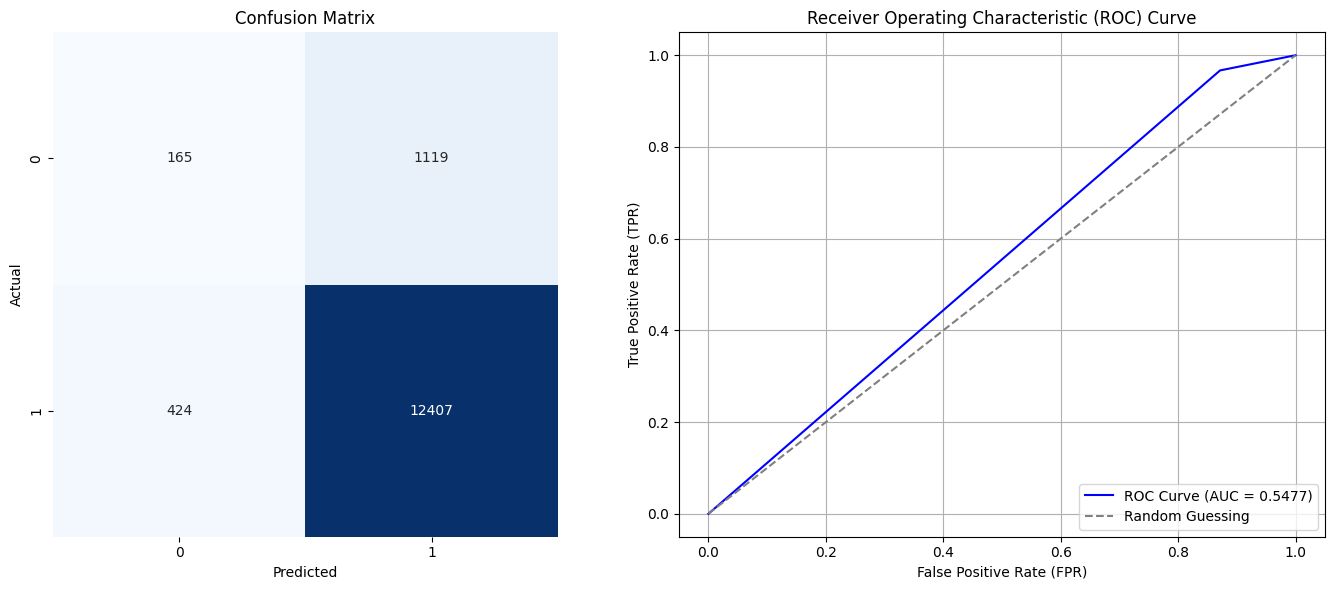

In [73]:
evaluation(y_test, y_pred)

Balanced

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

mlp = MLPClassifier(random_state=42, max_iter=500)

smote = SMOTE(random_state=42)

pipeline = Pipeline([
    ('smote', smote),  
    ('mlp', mlp)       
])

param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64,)],
    'mlp__activation': ['relu', 'tanh'],                      
    'mlp__solver': ['adam', 'sgd'],                              
    'mlp__alpha': [0.0001, 0.001, 0.01],                               
    'mlp__learning_rate': ['constant', 'adaptive']                
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring=f1_label_0, cv=skf, n_jobs=-1, random_state=42, n_iter=10)
grid_search.fit(X_train, y_train)


y_pred = grid_search.best_estimator_.predict(X_test)
print("Best Parameters:", grid_search.best_params_)

joblib.dump(grid_search.best_estimator_, 'balanced_nn.joblib')

Best Parameters: {'mlp__solver': 'sgd', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (32,), 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}


['balanced_nn.joblib']

classification report: 
               precision    recall  f1-score   support

           0       0.20      0.78      0.32      1284
           1       0.97      0.69      0.81     12831

    accuracy                           0.70     14115
   macro avg       0.59      0.74      0.56     14115
weighted avg       0.90      0.70      0.76     14115



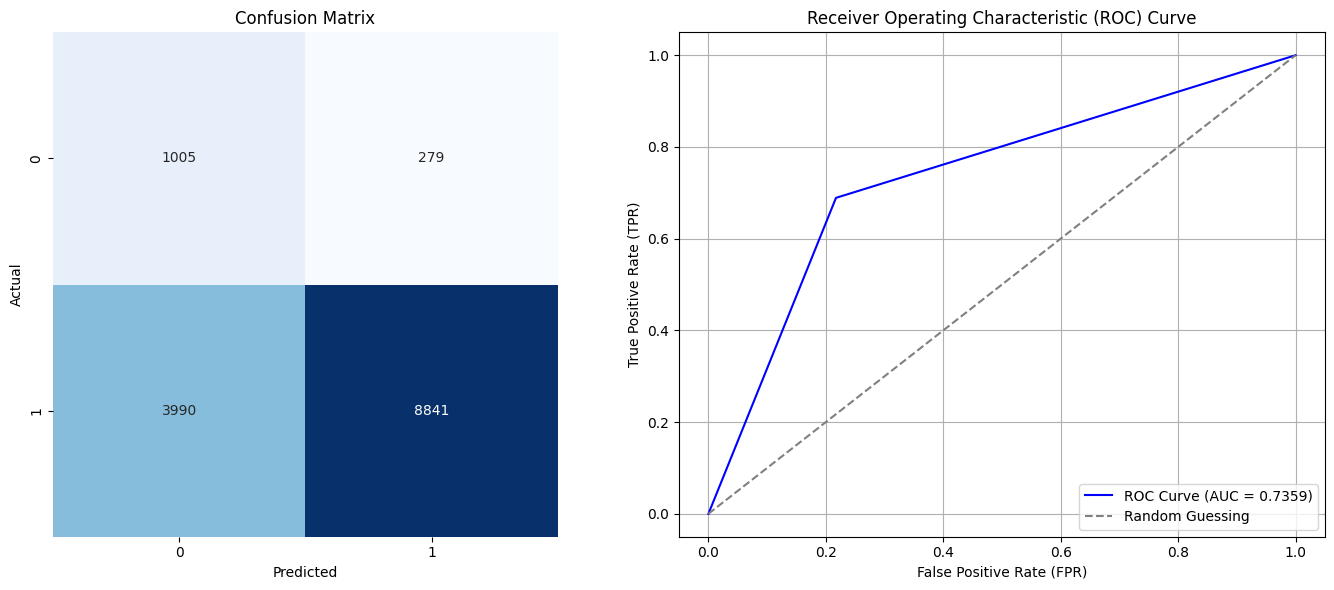

In [80]:
evaluation(y_test, y_pred)